# Plots 

In [1]:
import numpy as np
import sys 
import iceMACS
import xarray as xr
import seaborn as sns
import datetime
from tqdm import tqdm
import matplotlib

%load_ext autoreload
%autoreload 2

images_path = '/home/d/Dennys.Erdtmann/Thesis/Thesis-Document/Images/'

/usr/lib/python3/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
## General consistent style to fit Thesis 

import numpy as np
import matplotlib.pyplot as plt

textwidth = 6.26894
fontsize = 7
gr = 1.618
res = 400

# Set the font family and size to match your LaTeX document

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = fontsize
#plt.rcParams['text.usetex'] = True

# Set consistent font sizes for labels and titles
plt.rcParams['axes.labelsize'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize+1
plt.rcParams['legend.fontsize'] = fontsize
plt.rcParams['legend.title_fontsize'] = fontsize

plt.rcParams['lines.linewidth'] = 0.7
plt.rcParams['axes.linewidth'] = 0.7

def commit(filename):   
    plt.savefig(images_path+filename, bbox_inches='tight', dpi=400)
    return 

In [3]:
name_dict = {"hollow_bullet_rosette":"HBR", 
             "column_8elements":"8-col.", 
             "droxtal":"drox.", 
             "ghm":"GHM", 
             "plate":"plate", 
             "plate_10elements":"10-plate", 
             "plate_5elements":"5-plate", 
             "solid_bullet_rosette":"SBR",
             "solid_column":"SC",
             "hollow_column":"HC"}

name_dict_rough = {"hollow_bullet_rosette":"HBR_r", 
             "column_8elements":"8-col_r", 
             "droxtal":"drox_r", 
             "ghm":"GHM", 
             "plate":"plate_r", 
             "plate_10elements":"10-plate_r", 
             "plate_5elements":"5-plate_r", 
             "solid_bullet_rosette":"SBR_r",
             "solid_column":"SC_r",
             "hollow_column":"HC_r"}

name_dict_smooth = {"hollow_bullet_rosette":"HBR_s", 
             "column_8elements":"8-col_s", 
             "droxtal":"drox_s", 
             "ghm":"GHM", 
             "plate":"plate_s", 
             "plate_10elements":"10-plate_s", 
             "plate_5elements":"5-plate_s", 
             "solid_bullet_rosette":"SBR_s",
             "solid_column":"SC_s",
             "hollow_column":"HC_s"}

single_habits = ["solid_column", "hollow_column", "plate", "droxtal"]
aggregate_habits = ["column_8elements", "plate_5elements", "plate_10elements"]
bullet_rosette_habits = ["solid_bullet_rosette", "hollow_bullet_rosette"]

plate_habits = ["plate", "plate_5elements", "plate_10elements"]
column_habits = ["solid_column", "hollow_column", "column_8elements"]
bullet_rosette_and_droxtal_habits = ["solid_bullet_rosette", "hollow_bullet_rosette", "droxtal"]

## Pixel interplator

In [69]:
import datetime

start_time = datetime.datetime(2022, 3, 13, 8, 51, 0)
end_time = datetime.datetime(2022, 3, 13, 8, 56, 5)

nas_scene, swir_scene_raw, vnir_scene_raw = iceMACS.load_AC3_scene(start_time, end_time, vnir=False)
swir_scene = swir_scene_raw.sel(wavelength=[1250, 1600], method='nearest').load()

from iceMACS.tools import PixelInterpolator
interp = PixelInterpolator(swir_scene, window=2)

Load bahamas data...
Load and calibrate SWIR data...
{'units': 'degree', 'long_name': 'central across track angle of given pixel'}


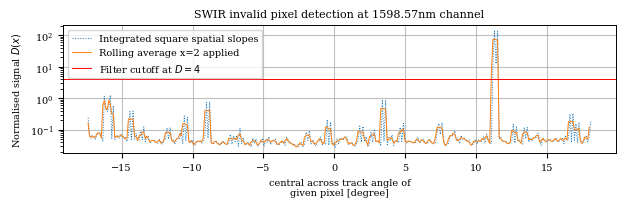

In [94]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/3))
data_sel = interp.data.sel(wavelength=2150, method='nearest')
data_sel.int_slopes.plot(linestyle='dotted', label='Integrated square spatial slopes')
data_sel.int_slopes_mva.plot(label=f"Rolling average x={interp.window} applied")
ax.set_ylabel(r'Normalised signal $D(x)$')
ax.set_title(f"SWIR invalid pixel detection at {data_sel.wavelength.values.item():.2f}nm channel")
ax.axhline(4, color='red', label=r"Filter cutoff at $D=4$")
plt.yscale('log')
plt.grid(alpha=0.8)
plt.legend()
plt.tight_layout()
commit("filter_threshold_demo.png")

## Cirrus cloud spectrum &rarr; choice of wavelengths

In [485]:
icLUT = iceMACS.read_LUT('ic_spectral_LUT.nc')

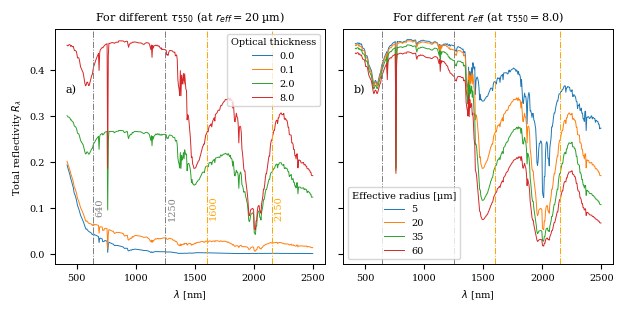

In [491]:
fig, axis = plt.subplots(nrows=1, ncols=2, figsize=(textwidth, textwidth/2.), sharey=True)

tau_vlines = [640, 1250]
r_vlines = [1600, 2150]

for tau550 in icLUT.coords["tau550"].values:
    icLUT_left = icLUT.sel(r_eff=25, method='nearest')
    icLUT_left.sel(tau550=tau550).reflectivity.plot(label=np.round(tau550, 2), ax=axis[0])

axis[0].legend(title=r"Optical thickness")

for r_eff in icLUT.coords["r_eff"].values:
    icLUT_right = icLUT.sel(tau550=8, method='nearest')
    icLUT_right.sel(r_eff=r_eff).reflectivity.plot(label=np.round(r_eff, 2), ax=axis[1])

axis[1].legend(title="Effective radius [µm]")
axis[1].set_ylabel(None)

# Annotate vertical lines with labels
for ax in axis:
    for wvl in tau_vlines:
        ax.axvline(wvl, color="grey", linestyle="-.")
        if ax==axis[0]:
            ax.annotate(
            str(wvl),
            xy=(wvl, 0.1),
            xytext=(5, 0),
            textcoords="offset points",
            ha="center",
            va="center",
            rotation=90,
            fontsize=fontsize,
            color="grey",
        )
    for wvl in r_vlines:
        ax.axvline(wvl, color="orange", linestyle="-.")
        if ax==axis[0]:
            ax.annotate(
            str(wvl),
            xy=(wvl, 0.1),
            xytext=(5, 0),
            textcoords="offset points",
            ha="center",
            va="center",
            rotation=90,
            fontsize=fontsize,
            color="orange",
        )

tau=r"$\tau_{550}$"
axis[0].set_title(f"For different {tau} (at {r'$r_{eff} =$'}{icLUT_left.r_eff.values.item()} µm)")
axis[1].set_title(r"For different $r_{eff}$ (at $\tau_{550} =$"+f"{icLUT_right.tau550.values.item()})")
axis[0].set_ylabel(r"Total reflectivity $R_{\lambda}$")
axis[0].set_xlabel(r"$\lambda$ [nm]")
axis[0].text(400, 0.35, "a)", fontsize=fontsize+1)
axis[1].text(400, 0.35, "b)", fontsize=fontsize+1)
axis[1].set_xlabel(r"$\lambda$ [nm]")
plt.tight_layout()

# Save the plot with a vector format for high quality
commit('ic_spectrum.png')

## Nakajima-King LUT presentation

In [466]:
from iceMACS.tools import BSRLookupTable
#LUT = BSRLookupTable.from_path('example_nadir_LUT.nc')
inverted_hd = iceMACS.read_LUT("example_nadir_LUT_inverted.nc")

In [467]:
exampleLUT = iceMACS.read_LUT('example_nadir_LUT.nc')

In [468]:
LUT = BSRLookupTable(exampleLUT.sel(wvl=[1250, 1600], method='nearest'))

In [469]:
LUT1 = BSRLookupTable(exampleLUT.sel(wvl=[1250, 1600], method='nearest'))
LUT2 = BSRLookupTable(exampleLUT.sel(wvl=[1250, 2150], method='nearest'))
LUT3 = BSRLookupTable(exampleLUT.sel(wvl=[640, 2150], method='nearest'))
LUT4 = BSRLookupTable(exampleLUT.sel(wvl=[640, 1600], method='nearest'))

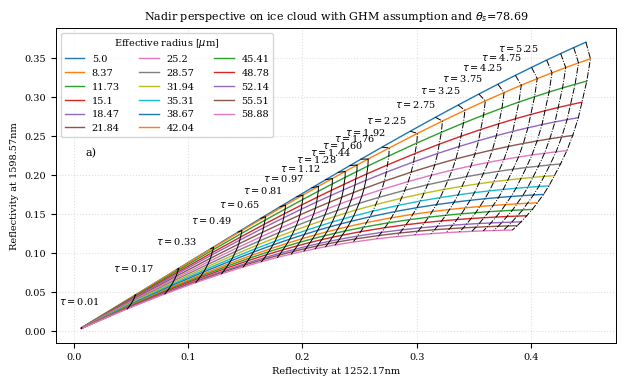

In [482]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/gr))

LUTcut = LUT.dataset.isel(phi=0, umu=0, sza=0, ic_habit=0).sel(r_eff=LUT.dataset.r_eff[::3], tau550=LUT.dataset.tau550[::2])

#LUTcut_downsampled = LUTcut.sel(r_eff=LUTcut.r_eff[::3], tau550=xr.concat([LUTcut.tau550[0:-1:3], LUTcut.tau550[-1]], dim='tau550'))

LUTcut1 = LUTcut.sel(wvl=LUT.wvl1)
LUTcut2 = LUTcut.sel(wvl=LUT.wvl2)

for r_eff in LUTcut.coords['r_eff'].values:
    ax.plot(LUTcut1.sel(r_eff=r_eff).reflectivity.to_numpy(), 
            LUTcut2.sel(r_eff=r_eff).reflectivity.to_numpy(),
            linewidth=1, label=np.round(r_eff, 2))

for itau550, tau550 in enumerate(LUTcut.coords['tau550'].values):
    if tau550<2:
        ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
                LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
                color="black",
                linewidth=0.7)

        x = np.max(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy())
        y = np.max(LUTcut2.sel(tau550=tau550).reflectivity.to_numpy())+0.03
        eq = r"$\tau=$"
    
        if itau550%1 == 0:
            plt.text(x-0.02,y, f"{eq}{tau550:.2f}", fontsize=fontsize, color='black')
        
    if tau550>=2:
        ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
                LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
                "-.", color="black",
                linewidth=0.7)

        x = np.max(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy())
        y = np.max(LUTcut2.sel(tau550=tau550).reflectivity.to_numpy())+0.03
        eq = r"$\tau=$"
        
        if itau550%1 == 0 and tau550<5.75:
            plt.text(x-0.02,y, f"{eq}{tau550:.2f}", fontsize=fontsize, color='black')
        
plt.text(0.01, 0.225, "a)", fontsize=fontsize+1)    
ax.set_xlabel(f"Reflectivity at {LUT.wvl1}nm")
ax.set_ylabel(f"Reflectivity at {LUT.wvl2}nm")
ax.legend(title=r"Effective radius [$\mu$m]", ncols=3)
theta_s = r"$\theta_s$"
plt.title(f"Nadir perspective on ice cloud with GHM assumption and {theta_s}={LUT.dataset.sza.values.item()}")
plt.grid(alpha=0.4, linestyle='dotted')
plt.tight_layout()

commit("bispectralLUT.png")

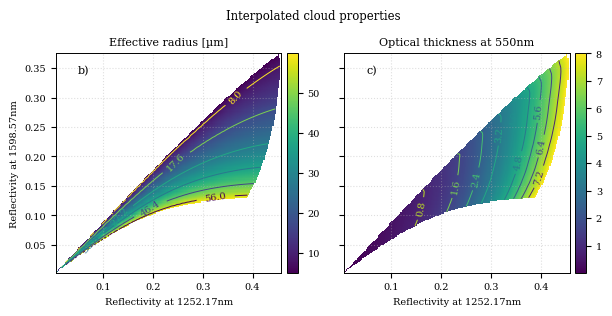

In [483]:
fig, ax = plt.subplots(ncols=2, figsize=(textwidth, textwidth/2), sharey=True)

LUTcut = inverted_hd.isel(phi=0, umu=0, sza=0, ic_habit=0)

ax[0].grid(alpha=0.4, linestyle='dotted')
ax[1].grid(alpha=0.4, linestyle='dotted')

r_eff_levels=np.linspace(8, 56, num=6)
LUTcut.sel(input_params='r_eff').reflectivity.plot(ax=ax[0], x=LUT.Rone_name, cbar_kwargs={'label': None, 
                                                                                            'pad':0.02})
plt.clabel(LUTcut.sel(input_params='r_eff').reflectivity.plot.contour(ax=ax[0], x=LUT.Rone_name, cmap='viridis_r', 
                                    levels=r_eff_levels), inline=True, fontsize=fontsize)
LUTcut.sel(input_params='tau550').reflectivity.plot(ax=ax[1], x=LUT.Rone_name, cbar_kwargs={'label': None, 
                                                                                            'pad':0.02})
plt.clabel(LUTcut.sel(input_params='tau550').reflectivity.plot.contour(ax=ax[1], x=LUT.Rone_name, cmap='viridis_r', 
                                    levels=14), inline=True, fontsize=fontsize)
ax[0].set_xlabel(f"Reflectivity at {LUT.wvl1}nm")
ax[0].set_ylabel(f"Reflectivity at {LUT.wvl2}nm")
ax[0].set_title(f"Effective radius [µm]")
ax[0].text(0.05, 0.34, "b)", fontsize=fontsize+1)

ax[1].set_xlabel(f"Reflectivity at {LUT.wvl1}nm")
ax[1].set_ylabel(None)
ax[1].set_title(f"Optical thickness at 550nm")
ax[1].text(0.05, 0.34, "c)", fontsize=fontsize+1)
fig.suptitle("Interpolated cloud properties")
plt.tight_layout()

commit("inverted_params.png")

## Choice of 1600 nm channel over 2150 nm

## MYSTIC polarized results and srfs sampling

## SWIR viewing geometry 

In [10]:
swir_data = iceMACS.read_LUT('../scene2/data/merged_data.nc')

In [11]:
swir_data

<xarray.Dataset>
Dimensions:       (x: 320, wavelength: 4, time: 9072)
Coordinates:
  * x             (x) float64 18.11 18.0 17.9 17.8 ... -17.17 -17.27 -17.38
  * wavelength    (wavelength) float64 1.252e+03 1.548e+03 1.699e+03 2.15e+03
  * time          (time) datetime64[ns] 2022-03-13T08:51:00.001951 ... 2022-0...
Data variables:
    radiance      (x, wavelength, time) float64 ...
    alt           (x, wavelength) float64 ...
    act           (x, wavelength) float64 ...
    valid         (x, wavelength) uint8 ...
    umu           (time, x) float64 ...
    phi           (time, x) float64 ...
    reflectivity  (x, wavelength, time) float64 ...
    sza           (time) float64 ...
    saa           (time) float64 ...
    d             (time) float64 ...
    vaa           (time, x) float64 ...
    vza           (time, x) float64 ...
Attributes:
    source_name:  swir
    sw_vers:      DAQ sw ver 0.3 (c++/roc)
    user_meta:    {"captureId":"32d67221-7246-4b5d-8d80-ac148edfd014","userMe...

In [ ]:
vza = swir_data.vza
vaa = swir_data.vaa

umu = swir_data.umu
phi = swir_data.phi


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(textwidth, textwidth/(gr)), sharey=True, sharex=True)

vza.plot(ax=ax[0, 0], x='time', alpha=0.8, cbar_kwargs={'label': None, 'pad':0.02})
plt.clabel(vza.plot.contour(ax=ax[0, 0], x='time', cmap='coolwarm_r', levels=10), 
           inline=True, fontsize=fontsize)
theta = r"$\theta$"
ax[0, 0].set_title(f"Viewing zenith angle {theta} [deg]")
        
vaa.plot(ax=ax[0, 1], x='time', alpha=0.8, cbar_kwargs={'label': None, 'pad':0.02})
plt.clabel(vaa.plot.contour(ax=ax[0, 1], x='time', cmap='coolwarm_r', levels=10), 
           inline=True, fontsize=fontsize)
varphi = r"$\varphi$"
ax[0, 1].set_title(f"Viewing azimuth angle {varphi} [deg]")
ax[0, 1].set_ylabel(None)

umu.plot(ax=ax[1, 0], x='time', alpha=0.8, cbar_kwargs={'label': None, 'pad':0.02})
plt.clabel(umu.plot.contour(ax=ax[1, 0], x='time', cmap='coolwarm_r', levels=10), 
           inline=True, fontsize=fontsize)
eq = r"$\mu = \cos(\theta)$"
ax[1, 0].set_title(f"{eq}")

phi_rel = r"$\phi$"
phi.plot(ax=ax[1, 1], x='time', alpha=0.8, cbar_kwargs={'label': None, 'pad':0.02})
plt.clabel(phi.plot.contour(ax=ax[1, 1], x='time', cmap='coolwarm_r', levels=10), 
           inline=True, fontsize=fontsize)
ax[1, 1].set_title(f"Relative viewing azimuth angle {phi_rel} [deg]")
ax[1, 1].set_ylabel(None)

ax[0, 0].set_xticks([])
plt.tight_layout()

commit("swir_view_geometry.png")

## Campaign flights overview

In [338]:
directory_path = "/archive/meteo/ac3/"
import os
all_items = os.listdir(directory_path)

desired_folders = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item)) 
                   and (item.startswith("202203") or item.startswith("202204"))
                   and not item.startswith("20220414")
                   and not item.startswith("20220311")]

scene_folders = [item for item in all_items if os.path.isdir(os.path.join(directory_path, item)) 
                 and (item.startswith("20220313") or item.startswith("20220401") or item.startswith("20220408"))]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


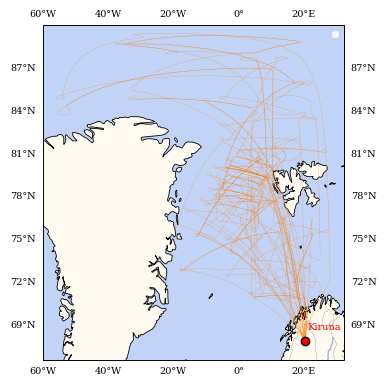

In [346]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

projection = ccrs.PlateCarree()

directory_path = "/archive/meteo/ac3/"
all_items = os.listdir(directory_path)

fig, ax = plt.subplots(nrows=1,ncols=1,
                       subplot_kw={'projection': projection},
                       figsize=(textwidth/gr,textwidth/gr))

for folder in desired_folders:
    
    folder_path = os.path.join(directory_path, folder)
    nas_file_path = folder_path+"/nas/AC3_HALO_BAHAMAS-SPECMACS-100Hz-final_"+folder+"a.nc"
    nas_file = iceMACS.read_LUT(nas_file_path)
    day_trajectory = nas_file.lon.values, nas_file.lat.values

    ax.plot(*day_trajectory, color='tab:orange', linestyle='--', linewidth=0.2, transform=projection)
    
# for folder in scene_folders:
    
#     folder_path = os.path.join(directory_path, folder)
#     nas_file_path = folder_path+"/nas/AC3_HALO_BAHAMAS-SPECMACS-100Hz-final_"+folder+"a.nc"
#     nas_file = iceMACS.read_LUT(nas_file_path)
#     day_trajectory = nas_file.lon.values, nas_file.lat.values

#     ax.plot(*day_trajectory, color="tab:red", linewidth=0.9, transform=projection, label="Selected scene")

    
    
kiruna_lon, kiruna_lat = 20.2251, 67.8555  # Kiruna, Sweden coordinates
ax.plot(kiruna_lon, kiruna_lat, 'o', markersize=6, color='black', transform=projection)
ax.plot(kiruna_lon, kiruna_lat, 'ro', markersize=4, transform=projection)
ax.text(kiruna_lon + 1, kiruna_lat+0.8, 'Kiruna', fontsize=fontsize, color='red', transform=projection)

for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)

plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False)

ax.add_feature(cfeature.LAND, facecolor='floralwhite')
ax.add_feature(cfeature.OCEAN, alpha=0.4, facecolor='cornflowerblue')
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.3)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

ax.set_aspect('auto')
# Add gridlines
ax.gridlines(draw_labels=True, linewidth=0, color='gray', linestyle='--')
#plt.legend()
# Set title and labels
#ax.set_title("Trajectories for Different Folders")
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")

# Adjust aspect ratio)
# Save the plot
#plt.savefig("trajectory_plot.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
#commit("overview_map.png")

## BSR sensitivity study

In [492]:
import seaborn as sns

In [493]:
sensitivity_data_ghm = xr.merge([iceMACS.read_LUT('../sensitivity_study/second_go/sim_data_ghm.nc'),
                                 iceMACS.read_LUT('../sensitivity_study/second_go/retrieved_sim_r_eff_ghm.nc').rename({'__xarray_dataarray_variable__':'r_eff_retrieved'}),
                                 iceMACS.read_LUT('../sensitivity_study/second_go/retrieved_sim_tau550_ghm.nc').rename({'__xarray_dataarray_variable__':'tau550_retrieved'})])

sensitivity_data_yang_rough = xr.merge([iceMACS.read_LUT('../sensitivity_study/second_go/sim_data_yang_rough.nc'),
                                 iceMACS.read_LUT('../sensitivity_study/second_go/retrieved_sim_r_eff_yang_rough.nc').rename({'__xarray_dataarray_variable__':'r_eff_retrieved'}),
                                 iceMACS.read_LUT('../sensitivity_study/second_go/retrieved_sim_tau550_yang_rough.nc').rename({'__xarray_dataarray_variable__':'tau550_retrieved'})])

sensitivity_data_yang_smooth = xr.merge([iceMACS.read_LUT('../sensitivity_study/second_go/sim_data_yang_smooth.nc'),
                                 iceMACS.read_LUT('../sensitivity_study/second_go/retrieved_sim_r_eff_yang_smooth.nc').rename({'__xarray_dataarray_variable__':'r_eff_retrieved'}),
                                 iceMACS.read_LUT('../sensitivity_study/second_go/retrieved_sim_tau550_yang_smooth.nc').rename({'__xarray_dataarray_variable__':'tau550_retrieved'})])

In [494]:
r_bias_ghm = (sensitivity_data_ghm.r_eff_retrieved - sensitivity_data_ghm.r_eff).sortby('r_eff').sortby('tau550')
tau_bias_ghm = (sensitivity_data_ghm.tau550_retrieved - sensitivity_data_ghm.tau550).sortby('r_eff').sortby('tau550')

r_bias_yang_rough = (sensitivity_data_yang_rough.r_eff_retrieved - sensitivity_data_yang_rough.r_eff).sortby('r_eff').sortby('tau550')
tau_bias_yang_rough = (sensitivity_data_yang_rough.tau550_retrieved - sensitivity_data_yang_rough.tau550).sortby('r_eff').sortby('tau550')

r_bias_yang_smooth = (sensitivity_data_yang_smooth.r_eff_retrieved - sensitivity_data_yang_smooth.r_eff).sortby('r_eff').sortby('tau550')
tau_bias_yang_smooth = (sensitivity_data_yang_smooth.tau550_retrieved - sensitivity_data_yang_smooth.tau550).sortby('r_eff').sortby('tau550')

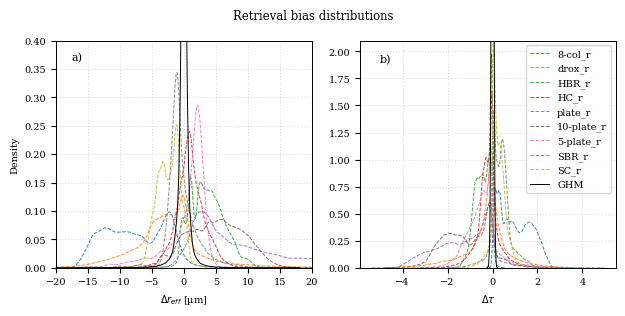

In [497]:
fig, ax = plt.subplots(ncols=2, figsize=(textwidth, textwidth/2))
color_counter=0
for habit in r_bias_yang_rough.ic_habit:
    r_bias_sel = r_bias_yang_rough.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_bias_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}")
    #r_bias_sel = r_bias.sel(ic_habit=habit).plot.hist(bins=200, label=habit.values, density=True)
    tau_bias_sel = tau_bias_yang_rough.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_bias_sel, ax=ax[1], label=name_dict_rough[habit.values.item()], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
#     r_bias_sel = r_bias_yang_smooth.sel(ic_habit=habit).values.flatten()
#     sns.kdeplot(data=r_bias_sel, ax=ax[0], alpha=0.9, linestyle='dotted', color=f"C{color_counter}")
#     #r_bias_sel = r_bias.sel(ic_habit=habit).plot.hist(bins=200, label=habit.values, density=True)
#     tau_bias_sel = tau_bias_yang_smooth.sel(ic_habit=habit).values.flatten()
#     sns.kdeplot(data=tau_bias_sel, ax=ax[1], alpha=0.9, 
#                 linestyle='dotted', color=f"C{color_counter}")
    color_counter += 1
    
r_bias_sel = r_bias_ghm.values.flatten()
sns.kdeplot(data=r_bias_sel, ax=ax[0], color='black')

tau_bias_sel = tau_bias_ghm.values.flatten()
sns.kdeplot(data=tau_bias_sel, ax=ax[1], color='black', label='GHM')

ax[0].text(-17.5, 0.365, "a)", fontsize=fontsize+1)
ax[1].text(-5, 1.9, "b)", fontsize=fontsize+1)
ax[1].legend()
ax[0].grid(alpha=0.4, linestyle='dotted')
ax[0].set_xlabel(r"$\Delta r_{eff}$ [µm]")
ax[1].grid(alpha=0.4, linestyle='dotted')
ax[0].set_xlim((-20, 20))
ax[0].set_ylim((0, 0.4))
ax[1].set_ylim((0, 2.1))
ax[1].set_ylabel("")
ax[1].set_xlabel(r"$\Delta \tau$")
fig.suptitle("Retrieval bias distributions")
plt.tight_layout()
commit("habit_error_kde.png")
plt.show()

In [498]:
r_re_ghm = r_bias_ghm/sensitivity_data_ghm.r_eff
r_re_yang_rough = r_bias_yang_rough/sensitivity_data_yang_rough.r_eff
r_re_yang_smooth = r_bias_yang_smooth/sensitivity_data_yang_smooth.r_eff

tau_re_ghm = tau_bias_ghm/sensitivity_data_ghm.tau550
tau_re_yang_rough = tau_bias_yang_rough/sensitivity_data_yang_rough.tau550
tau_re_yang_smooth = tau_bias_yang_smooth/sensitivity_data_yang_smooth.tau550

r_relative_error_function = (abs(r_re_ghm).mean(dim=("umu", "phi", "tau550")) + abs(r_re_yang_rough).mean(dim=("umu", "phi", "tau550", 'ic_habit')) + abs(r_re_yang_smooth).mean(dim=("umu", "phi", "tau550", 'ic_habit')))/3
tau_relative_error_function = (abs(tau_re_ghm).mean(dim=("umu", "phi", "r_eff")) + abs(tau_re_yang_rough).mean(dim=("umu", "phi", "r_eff", 'ic_habit')) + abs(tau_re_yang_smooth).mean(dim=("umu", "phi", "r_eff", 'ic_habit')))/3

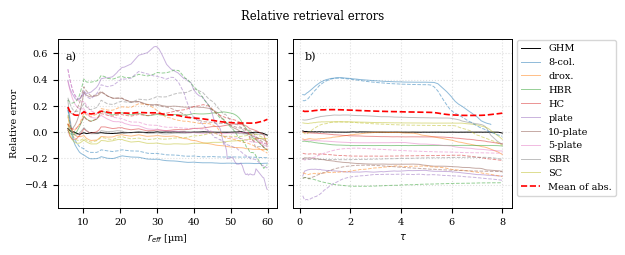

In [501]:
fig, ax = plt.subplots(ncols=2, figsize=(textwidth, textwidth/2.5), sharey=True)

r_re_ghm.mean(dim=("umu", "phi", "tau550")).plot(label='GHM', color='black', ax=ax[0])

color_counter=0
for habit in r_re_yang_rough.ic_habit:
    r_re_yang_rough.sel(ic_habit=habit).mean(dim=("umu", "phi", "tau550")).plot(label=name_dict[habit.values.item()], 
                                                                                color=f"C{color_counter}",
                                                                                alpha=0.5,
                                                                                ax=ax[0])
    color_counter += 1
    
color_counter=0
for habit in r_re_yang_smooth.ic_habit:
    r_re_yang_smooth.sel(ic_habit=habit).mean(dim=("umu", "phi", "tau550")).plot(linestyle='dashed', 
                                                                                 color=f"C{color_counter}",
                                                                                 alpha=0.5,
                                                                                 ax=ax[0])
    color_counter += 1

tau_re_ghm.mean(dim=("umu", "phi", "r_eff")).plot(label='GHM', color='black', ax=ax[1])


color_counter=0
for habit in r_re_yang_rough.ic_habit:
    tau_re_yang_rough.sel(ic_habit=habit).mean(dim=("umu", "phi", "r_eff")).plot(label=name_dict[habit.values.item()], 
                                                                                 ax=ax[1], 
                                                                                 alpha=0.5,
                                                                                 color=f"C{color_counter}")
    color_counter += 1
    
color_counter = 0
for habit in r_re_yang_smooth.ic_habit:
    tau_re_yang_smooth.sel(ic_habit=habit).mean(dim=("umu", "phi", "r_eff")).plot(linestyle='dashed', 
                                                                                  alpha=0.5,
                                                                                  color=f"C{color_counter}",
                                                                                  ax=ax[1])
    color_counter += 1

r_relative_error_function.plot(ax=ax[0], linewidth=1.2, color='red', linestyle='dashed')
tau_relative_error_function.plot(ax=ax[1], linewidth=1.2, color='red', linestyle='dashed', label="Mean of abs.")

fig.suptitle("Relative retrieval errors")   

ax[0].text(5, 0.55, "a)", fontsize=fontsize+1)
ax[1].text(0.2, 0.55, "b)", fontsize=fontsize+1)
ax[0].set_ylabel("Relative error")
ax[0].set_xlabel(r"$r_{eff}$ [µm]")
ax[0].set_title(None)
ax[0].grid(alpha=0.4, linestyle='dotted')
ax[1].set_xlabel(r"$\tau$")
ax[1].set_title(None)
ax[1].legend(bbox_to_anchor=(1.0, 1.02), loc="upper left")
ax[1].grid(alpha=0.4, linestyle='dotted')
plt.tight_layout()
commit("relative_retrieval_errors.png")

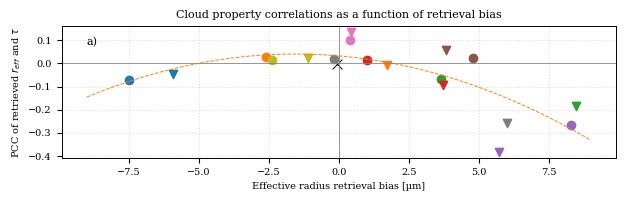

In [505]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/3.1))
coeffs = []
Bs = []

coeff = xr.corr(sensitivity_data_ghm.r_eff_retrieved, 
                    sensitivity_data_ghm.tau550_retrieved).values
coeffs.append(coeff)

B_r = r_bias_ghm.mean()
Bs.append(B_r)

plt.scatter(B_r, coeff, marker='x', label="GHM (correct)", color='black', s=50)
color_counter=0

for habit in sensitivity_data_yang_rough.ic_habit:
    coeff = xr.corr(sensitivity_data_yang_rough.sel(ic_habit=habit).r_eff_retrieved, 
                    sensitivity_data_yang_rough.sel(ic_habit=habit).tau550_retrieved).values
    coeffs.append(coeff)
    
    B_r = r_bias_yang_rough.sel(ic_habit=habit).mean()
    Bs.append(B_r)
    
    plt.scatter(B_r, coeff, label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")
    color_counter += 1

color_counter=0
for habit in sensitivity_data_yang_smooth.ic_habit:
    coeff = xr.corr(sensitivity_data_yang_smooth.sel(ic_habit=habit).r_eff_retrieved, 
                    sensitivity_data_yang_smooth.sel(ic_habit=habit).tau550_retrieved).values
    coeffs.append(coeff)
    
    B_r = r_bias_yang_smooth.sel(ic_habit=habit).mean()
    Bs.append(B_r)
    
    plt.scatter(B_r, coeff, label=name_dict_smooth[habit.values.item()], marker='v', color=f"C{color_counter}")
    color_counter += 1
    
# Fit
indices = np.array(Bs).argsort()
sorted_Bs = np.array(Bs)[indices]
sorted_coeffs = np.array(coeffs)[indices]

def polynomial_func(x, a, b, c):
    return a * x**2 + b * x + c

from scipy.optimize import curve_fit
params, cov = curve_fit(polynomial_func, sorted_Bs, sorted_coeffs)
plt.plot(np.linspace(-9, 9, num=100), polynomial_func(np.linspace(-9, 9, num=100), *params), 
         color="tab:orange", linestyle="dashed", label="Quadratic fit")

plt.axvline(0, alpha=0.8, color='Gray')
plt.axhline(0, alpha=0.8, color='Gray')
plt.xlabel("Effective radius retrieval bias [µm]")
plt.ylabel(r"PCC of retrieved $r_{eff}$ and $\tau$")
plt.grid(alpha=0.4, linestyle='dotted')
#plt.legend(loc='lower left', ncols=3)
plt.title(r"Cloud property correlations as a function of retrieval bias")
plt.text(-9, 0.08, "a)", fontsize=fontsize+1)
plt.tight_layout()
commit("r_eff_error_corr.png")

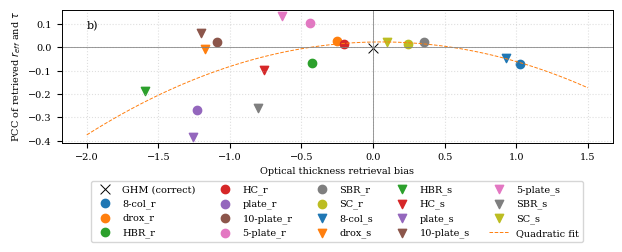

In [508]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/2.3))
coeffs = []
Bs = []

coeff = xr.corr(sensitivity_data_ghm.r_eff_retrieved, 
                    sensitivity_data_ghm.tau550_retrieved).values
coeffs.append(coeff)

B_r = tau_bias_ghm.mean()
Bs.append(B_r)

plt.scatter(B_r, coeff, marker='x', label="GHM (correct)", color='black', s=50)
color_counter=0

for habit in sensitivity_data_yang_rough.ic_habit:
    coeff = xr.corr(sensitivity_data_yang_rough.sel(ic_habit=habit).r_eff_retrieved, 
                    sensitivity_data_yang_rough.sel(ic_habit=habit).tau550_retrieved).values
    coeffs.append(coeff)
    
    B_r = tau_bias_yang_rough.sel(ic_habit=habit).mean()
    Bs.append(B_r)
    
    plt.scatter(B_r, coeff, label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")
    color_counter += 1

color_counter=0
for habit in sensitivity_data_yang_smooth.ic_habit:
    coeff = xr.corr(sensitivity_data_yang_smooth.sel(ic_habit=habit).r_eff_retrieved, 
                    sensitivity_data_yang_smooth.sel(ic_habit=habit).tau550_retrieved).values
    coeffs.append(coeff)
    
    B_r = tau_bias_yang_smooth.sel(ic_habit=habit).mean()
    Bs.append(B_r)
    
    plt.scatter(B_r, coeff, label=name_dict_smooth[habit.values.item()], marker='v', color=f"C{color_counter}")
    color_counter += 1
    
# Fit
indices = np.array(Bs).argsort()
sorted_Bs = np.array(Bs)[indices]
sorted_coeffs = np.array(coeffs)[indices]

def polynomial_func(x, a, b, c):
    return a * x**2 + b * x + c

from scipy.optimize import curve_fit
params, cov = curve_fit(polynomial_func, sorted_Bs, sorted_coeffs)
plt.plot(np.linspace(-2, 1.5, num=100), polynomial_func(np.linspace(-2, 1.5, num=100), *params), 
         color="tab:orange", linestyle="dashed", label="Quadratic fit")

plt.axvline(0, alpha=0.8, color='Gray')
plt.axhline(0, alpha=0.8, color='Gray')
plt.xlabel("Optical thickness retrieval bias")
plt.ylabel(r"PCC of retrieved $r_{eff}$ and $\tau$")
plt.grid(alpha=0.4, linestyle='dotted')
plt.legend(loc='upper center', ncols=5, bbox_to_anchor=(0.5, -0.25))
plt.title(None)
plt.text(-2, 0.08, "b)", fontsize=fontsize+1)
plt.tight_layout()
commit("tau_error_corr.png")

In [110]:
string = ""
for habit in ["solid_column", "hollow_column", "column_8elements", "plate", "plate_5elements", 
              "plate_10elements", "solid_bullet_rosette", "hollow_bullet_rosette", "droxtal"]:

    #print("quantile:",  abs(r_bias_yang_rough.sel(ic_habit=habit)).quantile(0.68).values)
    string = string + f"{np.around(np.sqrt(np.square(tau_bias_yang_smooth.sel(ic_habit=habit)).mean()).values.item(), 2)}" + " & " 
string

'0.62 & 1.09 & 1.21 & 1.78 & 0.94 & 1.55 & 1.12 & 1.9 & 1.77 & '

In [115]:
data = r_bias_ghm.values.flatten()

In [117]:
from scipy import stats
# Remove NaN values from the data before performing the test
non_nan_data = data[~np.isnan(data)]

# Perform the Shapiro-Wilk test
statistic, p_value = stats.shapiro(non_nan_data)
alpha = 0.05

print("Shapiro-Wilk Test:")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

if p_value > alpha:
    print("The data appears to be normally distributed (fail to reject H0)")
else:
    print("The data does not appear to be normally distributed (reject H0)")


Shapiro-Wilk Test:
Statistic: 0.7025
P-value: 0.0000
The data does not appear to be normally distributed (reject H0)


/home/d/Dennys.Erdtmann/.local/lib/python3.8/site-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


## Habit retrieval demo

In [ ]:
inflight_B = iceMACS.read_LUT('../mystic_tests/calibration_files/specMACS_POLB_cal_CHB2021+inflight.nc')

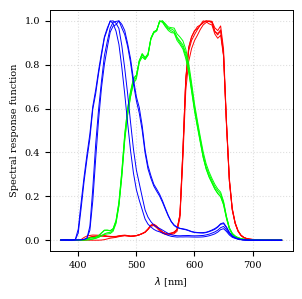

In [22]:
fig, ax = plt.subplots(figsize=(textwidth/2,textwidth/2))
inflight = inflight_B

for angle in inflight.angle:
    inflight.sel(color='red', angle=angle).srfs.plot(color='red')
    
for angle in inflight.angle:
    inflight.sel(color='green', angle=angle).srfs.plot(color='lime')
    
for angle in inflight.angle:
    inflight.sel(color='blue', angle=angle).srfs.plot(color='blue')
    
plt.grid(alpha=0.4, linestyle='dotted')
ax.set_title(None)
ax.set_xlabel(r"$\lambda$ [nm]")
ax.set_ylabel("Spectral response function")
commit("srfs.png")

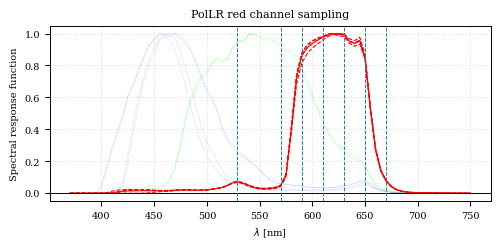

In [23]:
peak_samples = sorted(np.append(np.linspace(570, 670, num=6), 529))

fig, ax = plt.subplots(figsize=(0.8*textwidth,textwidth/2.5))

for angle in inflight_B.angle:
    inflight_B.sel(angle=angle, color='red').srfs.plot(label=angle.values, linewidth=0.8,
                                                       linestyle='dashed', color='red')
    inflight_B.sel(angle=angle, color='green').srfs.plot(label=angle.values, linewidth=0.2,
                                                       linestyle='dashed', color='lime', alpha=0.4)
    inflight_B.sel(angle=angle, color='blue').srfs.plot(label=angle.values, linewidth=0.2,
                                                       linestyle='dashed', color='blue', alpha=0.4)
    #inflight_A.sel(angle=angle, color='red').srfs.plot(label=angle.values, linestyle='dotted')
    
inflight_B.sel(color='red').mean(dim='angle').srfs.plot(label='mean', color='red')
    
plt.axhline(0, color='black')
for sample in peak_samples:
    plt.axvline(sample, linestyle='dashed', label='samples')

plt.title('PolLR red channel sampling')
ax.set_xlabel(r"$\lambda$ [nm]")
ax.set_ylabel("Spectral response function")
#plt.legend(title='Channel')
plt.grid(alpha=0.4, linestyle='dotted')
plt.tight_layout()
#plt.savefig('sampled_srf_red.png', bbox_inches='tight')
commit("red_channel_sampling.png")

In [25]:
from iceMACS.tools import PolLookupTable
polLUT = iceMACS.read_LUT('../mystic_tests/LUTs/RF03_pol_LUT_yang_smooth.nc')
#polLUT = iceMACS.read_LUT('../mystic_tests/LUTs/RF03_demo_pol_yang_LUT_rough.nc')
polLUTdemo_interp=PolLookupTable(polLUT)

In [26]:
reflectivity = polLUTdemo_interp.polarized_reflectivity().mean(dim='wvl')

In [27]:
reflectivity.coords

Coordinates:
  * phi       (phi) float64 0.0 15.65 31.3 46.96 ... 313.0 328.7 344.3 360.0
  * umu       (umu) float64 1.0 0.9928 0.9713 0.9359 ... 0.7518 0.6675 0.5736
  * sza       (sza) float64 78.69
  * r_eff     (r_eff) float64 5.0 32.5 60.0
  * tau550    (tau550) float64 0.01 0.0896 0.1692 0.2488 ... 5.429 5.714 6.0
  * ic_habit  (ic_habit) object 'solid_column' 'hollow_column' ... 'droxtal'

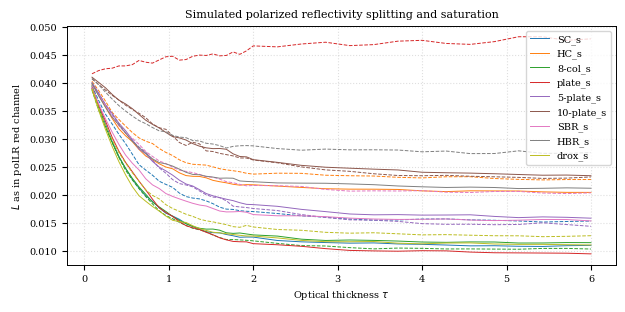

In [85]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/2))

window_size = 2
color_counter=0
for habit in polLUT.ic_habit:
    reflectivity.sel(umu=1, phi=0, r_eff=5, method='nearest').sel(ic_habit=habit).rolling(tau550=window_size).mean().plot(label=name_dict_smooth[habit.values.item()], color=f"C{color_counter}")
    #reflectivity.sel(umu=1, phi=0, r_eff=30, method='nearest').sel(ic_habit=habit).rolling(tau550=window_size).mean().plot(color=f"C{color_counter}", linestyle='dashed')
    reflectivity.sel(umu=1, phi=0, r_eff=60, method='nearest').sel(ic_habit=habit).rolling(tau550=window_size).mean().plot(color=f"C{color_counter}", linestyle='dashed')
    color_counter += 1
    
plt.ylabel(r'$L$ as in polLR red channel')
plt.xlabel(r"Optical thickness $\tau$")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4)
plt.title(None)
plt.legend()
plt.grid(alpha=0.4, linestyle='dotted')
plt.yscale('linear')
plt.title("Simulated polarized reflectivity splitting and saturation")
plt.tight_layout()
#commit("polarized_reflectivity_splitting.png")

In [754]:
Ray = iceMACS.read_LUT('../mystic_tests/LUTs/large_pol_yang_LUT_rough_no_maxsca.nc')
no_Ray = iceMACS.read_LUT('../mystic_tests/LUTs/no_Ray_sca_pol_yang_LUT_rough_no_maxsca.nc')

from iceMACS.tools import PolLookupTable
Ray_interp = PolLookupTable(Ray)
no_Ray_interp = PolLookupTable(no_Ray)

In [755]:
Ray_reflectivity = Ray_interp.polarized_reflectivity().mean(dim='wvl')
no_Ray_reflectivity = no_Ray_interp.polarized_reflectivity().mean(dim='wvl')

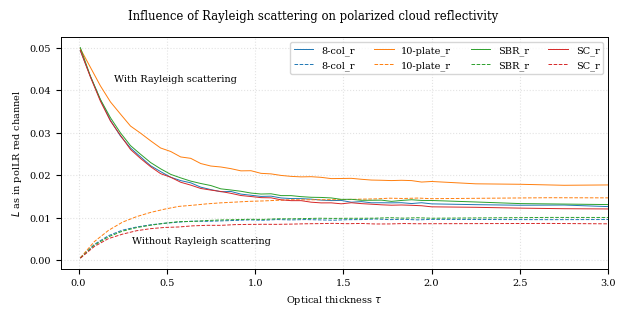

In [759]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/2))

window_size = 2
color_counter=0
for habit in Ray.ic_habit:
    Ray_reflectivity.sel(umu=1, phi=0, r_eff=5, method='nearest').sel(ic_habit=habit).plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")
    #reflectivity.sel(umu=1, phi=0, r_eff=30, method='nearest').sel(ic_habit=habit).rolling(tau550=window_size).mean().plot(color=f"C{color_counter}", linestyle='dashed')

    no_Ray_reflectivity.sel(umu=1, phi=0, r_eff=5, method='nearest').sel(ic_habit=habit).plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}", linestyle='dashed')
    #reflectivity.sel(umu=1, phi=0, r_eff=30, method='nearest').sel(ic_habit=habit).rolling(tau550=window_size).mean().plot(color=f"C{color_counter}", linestyle='dashed')

    color_counter += 1
    
plt.ylabel(r'$L$ as in polLR red channel')
plt.xlabel(r"Optical thickness $\tau$")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4)
plt.title(None)
plt.legend(ncols=4)
plt.grid(alpha=0.35, linestyle='dotted')
#plt.yscale('log')
plt.xlim(-0.1, 3)
fig.suptitle("Influence of Rayleigh scattering on polarized cloud reflectivity")
plt.text(0.3, 0.004, "Without Rayleigh scattering", color='black')
plt.text(0.2, 0.042, "With Rayleigh scattering", color='black')
plt.tight_layout()
commit("Rayleigh_influence.png")

## Maxscatter

In [229]:
maxsca = iceMACS.read_LUT('MT_maxsca.nc')
no_maxsca = iceMACS.read_LUT('MT_no_maxsca.nc')

In [323]:
maxsca

<xarray.Dataset>
Dimensions:   (wvl: 1, phi: 1, umu: 1, sza: 5, r_eff: 2, tau550: 50, ic_habit: 1)
Coordinates:
  * wvl       (wvl) int64 640
  * phi       (phi) int64 0
  * umu       (umu) int64 1
  * sza       (sza) int64 0 20 40 60 80
  * r_eff     (r_eff) int64 5 25
  * tau550    (tau550) float64 0.01 0.07102 0.132 0.1931 ... 2.878 2.939 3.0
  * ic_habit  (ic_habit) object 'ghm'
Data variables:
    I         (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 64.46 ......
    Q         (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 0.02667 ....
    U         (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 -0.01944 ...
    V         (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 1.437e-05...
    I_std     (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 0.06508 ....
    Q_std     (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 0.01527 ....
    U_std     (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 0.01504 ....
    V_std     (wvl, phi, umu, sza, r_eff, tau550, ic_habit) float64 3.219e-05...
Attributes:
    measurement:       Stokes parameters as measured 1 km above cloud top
    descr:             LUT phase functions for cloud without ground bpdf 
    input_template:    \n    data_files_path /project/meteo/work/Dennys.Erdtm...
    computation_time:  2.0671683087324104[min]

In [236]:
from iceMACS.tools import PolLookupTable
maxsca_interp = PolLookupTable(maxsca)
no_maxsca_interp = PolLookupTable(no_maxsca)

In [237]:
ref_maxsca = maxsca_interp.polarized_reflectivity()
ref = no_maxsca_interp.polarized_reflectivity()

In [290]:
error = ref - ref_maxsca
rel_error = error/ref

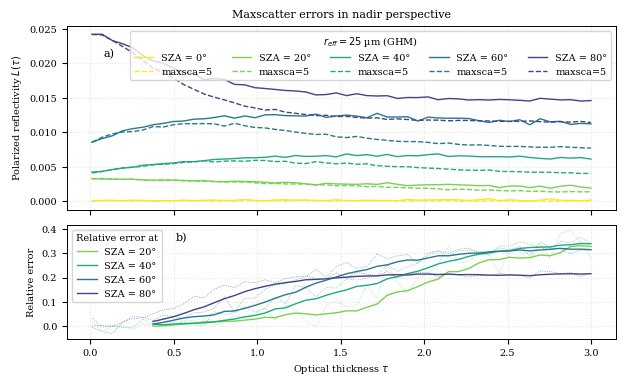

In [329]:
fig, ax = plt.subplots(nrows=2, figsize=(textwidth, textwidth/gr), sharex=True, gridspec_kw={'height_ratios': [gr, 1]})
cmap = plt.cm.viridis_r
for index, sza in enumerate(error.sza):
    
    ref.sel(r_eff=25, sza=sza).plot(color=cmap(index/5), label=f"SZA = {sza.values.item()}°", linewidth=1, ax=ax[0])
    ref_maxsca.sel(r_eff=25, sza=sza).plot(linestyle='dashed', color=cmap(index/5), linewidth=1, label="maxsca=5", ax=ax[0])
    if sza.values.item() != 0:
        rel_error.sel(r_eff=25, sza=sza).rolling(tau550=7).mean().plot(color=cmap(index/5), label=f"SZA = {sza.values.item()}°", linewidth=1, ax=ax[1])
        rel_error.sel(r_eff=25, sza=sza).rolling(tau550=1).mean().plot(color=cmap(index/5), linewidth=0.5, alpha=0.8, linestyle='dotted', ax=ax[1])

ax[0].legend(ncols=5, title=r"$r_{eff}=25$ µm (GHM)")
ax[1].legend(ncols=1, title=r"Relative error at")
ax[0].grid(alpha=0.35, linestyle='dotted')
ax[1].grid(alpha=0.35, linestyle='dotted')
ax[0].set_ylabel(r"Polarized reflectivity $L(\tau)$")
ax[1].set_ylabel(r"Relative error")
ax[1].set_xlabel(r"Optical thickness $\tau$")
ax[0].set_xlabel(None)
ax[0].set_title("Maxscatter errors in nadir perspective", fontsize=fontsize+1)
ax[1].set_title(None)

ax[0].text(0.08, 0.021, "a)", fontsize=fontsize+1)
ax[1].text(0.51, 0.35, "b)", fontsize=fontsize+1)

plt.tight_layout()
commit("maxsca_reflectivities.png")

In [313]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/2))
cmap = plt.cm.viridis_r
for index, sza in enumerate(error.sza):
    
    if sza.values.item() != 0:
        rel_error.sel(r_eff=25, sza=sza).rolling(tau550=7).mean().plot(color=cmap(index/5), label=f"SZA = {sza.values.item()}°", linewidth=1)
    #ref_maxsca.sel(r_eff=25, sza=sza).plot(linestyle='dashed', color=cmap(index/5), linewidth=1, label="maxsca=5")
    
plt.legend(ncols=1, title=r"$r_{eff}=25$ µm")
ax.grid(alpha=0.35, linestyle='dotted')
plt.ylabel(r"Relative error")
plt.xlabel(r"Optical thickness $\tau$")
plt.title(None)
#plt.yscale('log')
plt.tight_layout()
#commit("maxsca_reflectivities.png")

ValueError: Expected the given number of height ratios to match the number of rows of the grid

<Figure size 626.894x313.447 with 0 Axes>

## New reflectivity splitting

In [229]:
splitting_rough = iceMACS.read_LUT("L_saturation_5km_rough.nc")
splitting_smooth = iceMACS.read_LUT("L_saturation_5km_smooth.nc")

splitting_noRay_rough = iceMACS.read_LUT("L_saturation_5km_noRay_rough.nc")
splitting_noRay_smooth = iceMACS.read_LUT("L_saturation_5km_noRay_smooth.nc")

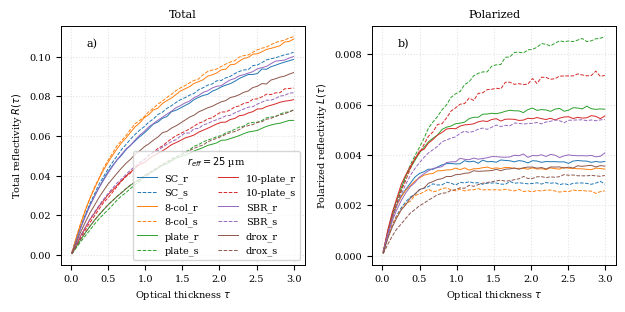

In [265]:
fig, axes = plt.subplots(ncols=2, figsize=(textwidth, textwidth/2))

ax=axes[0]
color_counter = 0
for habit in splitting_noRay_smooth.ic_habit:
    
    selected = splitting_noRay_rough.sel(r_eff=25).sel(ic_habit=habit)
    L = selected.I/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}", ax=ax)
    
    selected = splitting_noRay_smooth.sel(r_eff=25).sel(ic_habit=habit)
    L = selected.I/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(label=name_dict_smooth[habit.values.item()], color=f"C{color_counter}", linestyle='dashed', ax=ax)
    

    color_counter+=1
    
ax.set_xlabel(r"Optical thickness $\tau$")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4)
ax.set_title("Total")
ax.legend(ncols=2, title=r"$r_{eff}=25$ µm")
ax.grid(alpha=0.35, linestyle='dotted')
#plt.yscale('log')
#plt.xlim(-0.1, 3)
ax.set_ylabel(r"Total reflectivity $R(\tau)$")
ax.text(0.2, 0.105, "a)", fontsize=fontsize+1)

ax = axes[1]
color_counter = 0
for habit in splitting_noRay_smooth.ic_habit:
    
    selected = splitting_noRay_rough.sel(r_eff=25).sel(ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}", ax=ax)
    
    selected = splitting_noRay_smooth.sel(r_eff=25).sel(ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(label=name_dict_smooth[habit.values.item()], color=f"C{color_counter}", linestyle='dashed', ax=ax)

    color_counter+=1
    
ax.set_xlabel(r"Optical thickness $\tau$")
ax.set_ylabel(r"Polarized reflectivity $L(\tau)$")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4)
ax.set_title("Polarized")
ax.grid(alpha=0.35, linestyle='dotted')
#plt.yscale('log')
#plt.xlim(-0.1, 3)
ax.text(0.2, 0.0083, "b)", fontsize=fontsize+1)

plt.tight_layout()
commit("polarized_reflectivity_splitting.png")

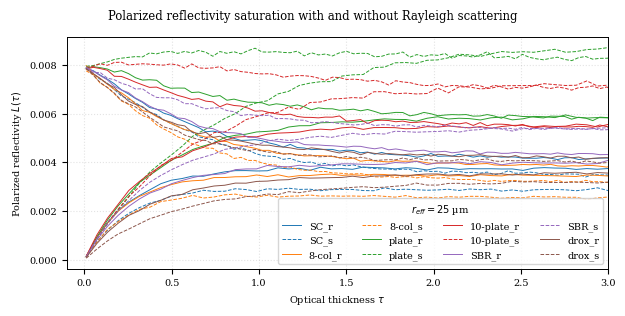

In [369]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/2))

color_counter = 0
for habit in splitting_noRay_smooth.ic_habit[::1]:
    
    selected = splitting_noRay_rough.sel(r_eff=25).sel(ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")
    
    selected = splitting_noRay_smooth.sel(r_eff=25).sel(ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(label=name_dict_smooth[habit.values.item()], color=f"C{color_counter}", linestyle='dashed')
    
    
    selected = splitting_rough.sel(r_eff=25).sel(ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(color=f"C{color_counter}")
    
    selected = splitting_smooth.sel(r_eff=25).sel(ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.plot(color=f"C{color_counter}", linestyle='dashed')
    

    color_counter+=1
    
plt.xlabel(r"Optical thickness $\tau$")
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, ncol=4)
plt.title(None)
plt.legend(ncols=4, title=r"$r_{eff}=25$ µm")
plt.grid(alpha=0.35, linestyle='dotted')
#plt.yscale('log')
plt.xlim(-0.1, 3)
plt.ylabel(r"Polarized reflectivity $L(\tau)$")
fig.suptitle("Polarized reflectivity saturation with and without Rayleigh scattering")
plt.tight_layout()
commit("Rayleigh_influence.png")

## Different ice crystal LUTs

In [3]:
import os
directory_path = "../scenes/MWAI_RF03/LUTs/final/"
all_items = os.listdir(directory_path)

smooth_LUTs = [directory_path+item
              for item
              in all_items if (item.startswith("RF03") and item.endswith("smooth_LUT.nc"))]

from iceMACS.tools import BSRLookupTable
#ghm_LUT = BSRLookupTable.from_path('LUTs/final/RF03_ghm_LUT.nc')

In [4]:
smooth_LUTs

['../scenes/MWAI_RF03/LUTs/final/RF03_column_8elements_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_hollow_column_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_plate_10elements_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_plate_5elements_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_plate_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_solid_bullet_rosette_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_droxtal_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_solid_column_smooth_LUT.nc',
 '../scenes/MWAI_RF03/LUTs/final/RF03_hollow_bullet_rosette_smooth_LUT.nc']

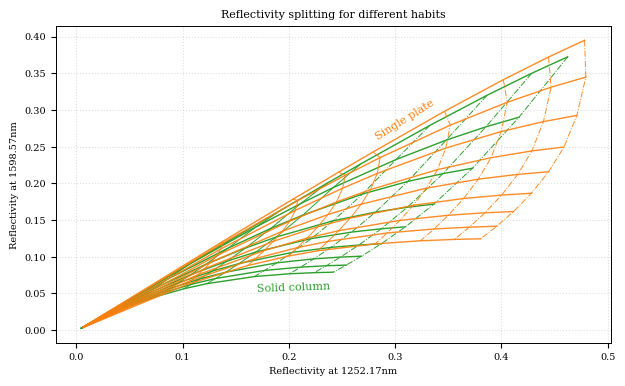

In [30]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth/gr))

LUT = BSRLookupTable.from_path('../scenes/MWAI_RF03/LUTs/final/RF03_plate_smooth_LUT.nc')
LUTcut = LUT.dataset.isel(phi=0, umu=0, sza=0, ic_habit=0).sel(r_eff=LUT.dataset.r_eff[::6], tau550=LUT.dataset.tau550[::6])

#LUTcut_downsampled = LUTcut.sel(r_eff=LUTcut.r_eff[::3], tau550=xr.concat([LUTcut.tau550[0:-1:3], LUTcut.tau550[-1]], dim='tau550'))

LUTcut1 = LUTcut.sel(wvl=LUT.wvl1)
LUTcut2 = LUTcut.sel(wvl=LUT.wvl2)

for r_eff in LUTcut.coords['r_eff'].values:
    ax.plot(LUTcut1.sel(r_eff=r_eff).reflectivity.to_numpy(), 
            LUTcut2.sel(r_eff=r_eff).reflectivity.to_numpy(),
            linewidth=1, label=np.round(r_eff, 2), color='C2')

for itau550, tau550 in enumerate(LUTcut.coords['tau550'].values):
    if tau550<2:
        ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
                LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
                color="C2",
                linewidth=0.7)
        
    if tau550>=2:
        ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
                LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
                "-.", color="C2",
                linewidth=0.7)
        
LUT = BSRLookupTable.from_path('../scenes/MWAI_RF03/LUTs/final/RF03_solid_column_smooth_LUT.nc')
LUTcut = LUT.dataset.isel(phi=0, umu=0, sza=0, ic_habit=0).sel(r_eff=LUT.dataset.r_eff[::6], tau550=LUT.dataset.tau550[::6])

#LUTcut_downsampled = LUTcut.sel(r_eff=LUTcut.r_eff[::3], tau550=xr.concat([LUTcut.tau550[0:-1:3], LUTcut.tau550[-1]], dim='tau550'))

LUTcut1 = LUTcut.sel(wvl=LUT.wvl1)
LUTcut2 = LUTcut.sel(wvl=LUT.wvl2)

for r_eff in LUTcut.coords['r_eff'].values:
    ax.plot(LUTcut1.sel(r_eff=r_eff).reflectivity.to_numpy(), 
            LUTcut2.sel(r_eff=r_eff).reflectivity.to_numpy(),
            linewidth=1, label=np.round(r_eff, 2), color='C1', alpha=0.9)

for itau550, tau550 in enumerate(LUTcut.coords['tau550'].values):
    if tau550<2:
        ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
                LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
                color="C1", alpha=0.9,
                linewidth=0.7)
        
    if tau550>=2:
        ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
                LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
                "-.", color="C1", alpha=0.9,
                linewidth=0.7)

plt.text(0.28, 0.26, "Single plate", color='C1', fontsize=8, rotation=32)
plt.text(0.17, 0.053, "Solid column", color='C2', fontsize=8, rotation=2)

ax.set_xlabel(f"Reflectivity at {LUT.wvl1}nm")
ax.set_ylabel(f"Reflectivity at {LUT.wvl2}nm")
#ax.legend(title=r"Effective radius [$\mu$m]", ncols=3)
theta_s = r"$\theta_s$"
plt.title(f"Reflectivity splitting for different habits")
plt.grid(alpha=0.4, linestyle='dotted')
plt.tight_layout()

commit("LUT_comparison.png")

## RF15

In [512]:
swir_scene = iceMACS.read_LUT("../scenes/polar_low_RF15/data/RF15_swir_scene.nc")
solar_positions = iceMACS.read_LUT('../scenes/polar_low_RF15/data/solar_positions.nc')
cloud_properties_rough = iceMACS.read_LUT('../scenes/polar_low_RF15/data/RF15_merged_cloud_properties_rough.nc')
cloud_properties_smooth = iceMACS.read_LUT('../scenes/polar_low_RF15/data/RF15_merged_cloud_properties_smooth.nc')
view_angles = iceMACS.read_LUT('../scenes/polar_low_RF15/data/view_angles.nc')

In [513]:
from iceMACS.tools import SceneInterpreter
scene = SceneInterpreter(swir_scene, view_angles, solar_positions)

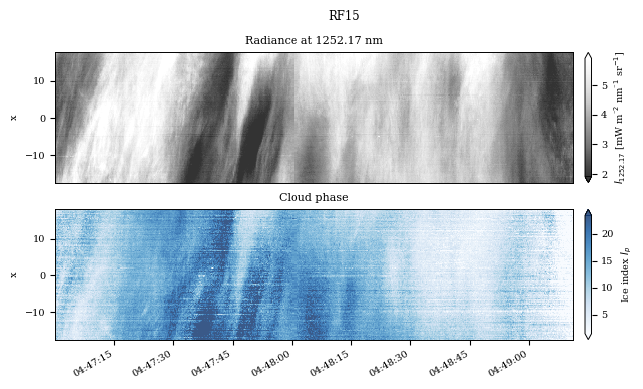

In [514]:
fig, ax = plt.subplots(nrows=2, figsize=(1.1*textwidth, textwidth/gr), gridspec_kw={'height_ratios': [1, 1]}, sharex=True)
alpha=0.8

swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[0], 
                                                                                           cmap='Greys_r', cbar_kwargs={'label':r"$I_{1252.17}$ [mW m$^{⁻2}$ nm$^{⁻1}$ sr$^{-1}$]" ,'pad':0.02}, alpha=alpha)
scene.ice_index_Jaekel2013().dropna(dim='x', how='all').rolling(x=2, time=2).mean().plot(x='time', robust=True, ax=ax[1], cbar_kwargs={'label':r"Ice index $I_p$" ,'pad':0.02}, alpha=alpha, cmap='Blues')
ax[0].set_xlabel(None)
ax[1].set_xlabel(None)
ax[0].set_title("Radiance at 1252.17 nm")
ax[1].set_title("Cloud phase")

for axis in ax:
    axis.set_ylabel('x')

ax[0].tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

fig.suptitle("RF15")
plt.tight_layout()

#commit("RF15_overview.png")

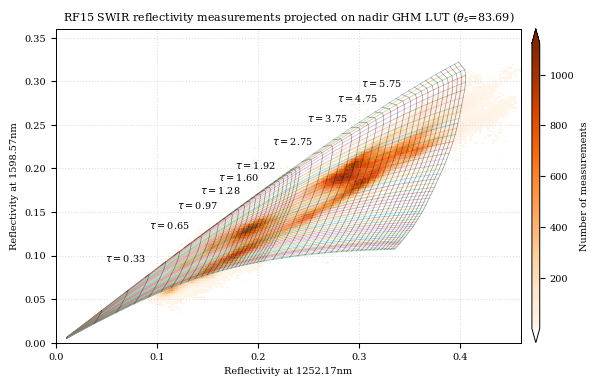

In [8]:
from iceMACS.tools import BSRLookupTable
LUT = BSRLookupTable.from_path('../scenes/polar_low_RF15/LUTs/disort/RF15_ghm_LUT.nc')


fig, ax = plt.subplots(figsize=(1*textwidth, textwidth/gr))

LUTcut = LUT.dataset.isel(phi=0, umu=0, sza=0, ic_habit=0).sel(r_eff=LUT.dataset.r_eff[::1], tau550=LUT.dataset.tau550[::1])

#LUTcut_downsampled = LUTcut.sel(r_eff=LUTcut.r_eff[::3], tau550=xr.concat([LUTcut.tau550[0:-1:3], LUTcut.tau550[-1]], dim='tau550'))


LUTcut1 = LUTcut.sel(wvl=LUT.wvl1)
LUTcut2 = LUTcut.sel(wvl=LUT.wvl2)

for r_eff in LUTcut.coords['r_eff'].values[::1]:
    ax.plot(LUTcut1.sel(r_eff=r_eff).reflectivity.to_numpy(), 
            LUTcut2.sel(r_eff=r_eff).reflectivity.to_numpy(),
            linewidth=0.6, label=np.round(r_eff, 2), alpha=0.4)

for itau550, tau550 in enumerate(LUTcut.coords['tau550'].values[::1]):

    ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
            LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
            color="black",
            linewidth=0.5, alpha=0.4)
    
for itau550, tau550 in enumerate(LUTcut.coords['tau550'].values[::4]):
    
    x = np.max(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy())
    y = np.max(LUTcut2.sel(tau550=tau550).reflectivity.to_numpy())+0.001
    eq = r"$\tau=$"
    
    if tau550>0.21 and tau550<6:
        plt.text(x-0.02,y, f"{eq}{tau550:.2f}", fontsize=fontsize, color='black', horizontalalignment="right")

cmap = plt.cm.Oranges
cmap.set_under(color='white')

R1 = scene.reflectivity().sel(wavelength=LUT.wvl1, method='nearest').values.flatten()
R2 = scene.reflectivity().sel(wavelength=LUT.wvl2, method='nearest').values.flatten()

valid_indices = np.logical_not(np.logical_or(np.isnan(R1), np.isnan(R2)))
R1_real = R1[valid_indices]
R2_real = R2[valid_indices]

hist = ax.hist2d(R1_real, R2_real, bins=150, vmin=1, cmap=cmap)
plt.colorbar(hist[3], ax=ax, label="Number of measurements", pad=0.02, extend='both', aspect=40)
            
ax.set_xlabel(f"Reflectivity at {LUT.wvl1}nm")
ax.set_ylabel(f"Reflectivity at {LUT.wvl2}nm")
#ax.legend(title=r"Effective radius [$\mu$m]", ncols=3)
theta_s = r"$\theta_s$"
plt.title(f"RF15 SWIR reflectivity measurements projected on nadir GHM LUT ({theta_s}={LUT.dataset.sza.values.item()})")
plt.grid(alpha=0.4, linestyle='dotted')
plt.xlim((0, 0.46))
plt.ylim((0, 0.36))
plt.tight_layout()

#commit("RF15_measurements_on_GHMLUT.png")

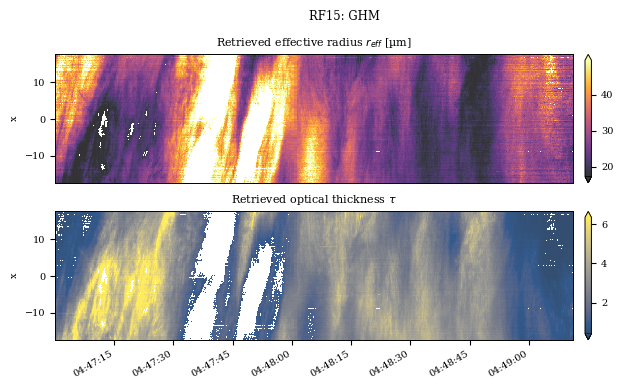

In [216]:
fig, ax = plt.subplots(nrows=2, figsize=(1.1*textwidth, textwidth/gr), sharex=True)
alpha=0.8

plot_cloud_properties = cloud_properties_rough.sel(ic_habit='ghm').rolling(x=2, time=2).mean()

plot_cloud_properties.r_eff.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[0], cmap='inferno', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[0].set_xlabel('')
ax[0].set_title(r"Retrieved effective radius $r_{eff}$ [µm]")

plot_cloud_properties.tau550.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[1], cmap='cividis', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[1].set_xlabel('')
ax[1].set_title(r"Retrieved optical thickness $\tau$")

for axis in ax:
    axis.set_ylabel('x')

ax[0].tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

fig.suptitle("RF15: GHM")
#plt.suptitle("Bispectral retrieval results with GHM assumption")
plt.tight_layout()

commit("RF15_cloud_properties_ghm.png")

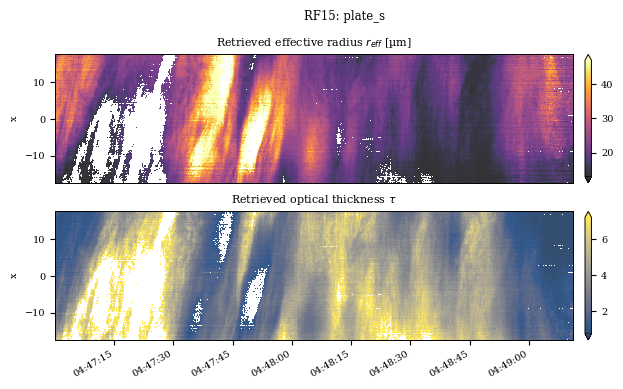

In [217]:
fig, ax = plt.subplots(nrows=2, figsize=(1.1*textwidth, textwidth/gr), sharex=True)
alpha=0.8

plot_cloud_properties = cloud_properties_smooth.sel(ic_habit='plate').rolling(x=2, time=2).mean()

plot_cloud_properties.r_eff.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[0], cmap='inferno', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[0].set_xlabel('')
ax[0].set_title(r"Retrieved effective radius $r_{eff}$ [µm]")

plot_cloud_properties.tau550.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[1], cmap='cividis', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[1].set_xlabel('')
ax[1].set_title(r"Retrieved optical thickness $\tau$")

for axis in ax:
    axis.set_ylabel('x')

ax[0].tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

fig.suptitle("RF15: plate_s")
#plt.suptitle("Bispectral retrieval results with GHM assumption")
plt.tight_layout()

commit("RF15_cloud_properties_plate_smooth.png")

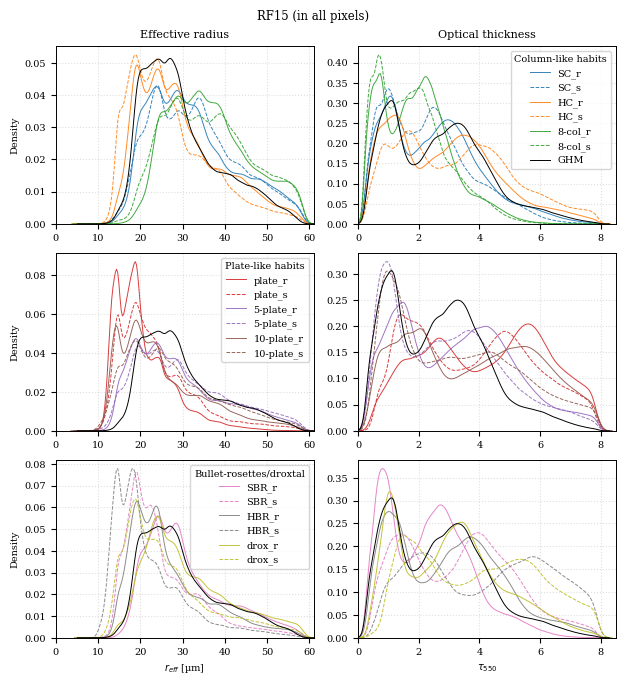

In [228]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(textwidth, textwidth*1.1))

ax = axes[0,:]
color_counter=0
for habit in column_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}")
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}")
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")

ax[1].set_ylabel(None)
ax[1].legend(title="Column-like habits")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')

ax[0].set_title(r"Effective radius", fontsize=8)
ax[1].set_title(r"Optical thickness", fontsize=8)

ax = axes[1,:]
for habit in plate_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}", label=name_dict_rough[habit])
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}", label=name_dict_smooth[habit])
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")


ax[1].set_ylabel(None)
ax[0].legend(title="Plate-like habits")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')
    

ax = axes[2,:]
for habit in bullet_rosette_and_droxtal_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}", label=name_dict_rough[habit])
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}", label=name_dict_smooth[habit])
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")

ax[1].set_ylabel(None)
ax[0].legend(title="Bullet-rosettes/droxtal")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')

ax[0].set_xlabel(r"$r_{eff}$ [µm]")
ax[1].set_xlabel(r"$\tau_{550}$")

for panel in axes[:,0]:
    panel.set_xlim((0,61))
for panel in axes[:,1]:
    panel.set_xlim((0,8.5))

fig.suptitle(r"RF15 (in all pixels)")
plt.tight_layout()
commit("RF15_all_hists.png")

In [218]:
unambig = 1
for habit in cloud_properties_rough.ic_habit:
    unambig = unambig*cloud_properties_rough.sel(ic_habit=habit)
for habit in cloud_properties_smooth.ic_habit:
    unambig = unambig*cloud_properties_rough.sel(ic_habit=habit)

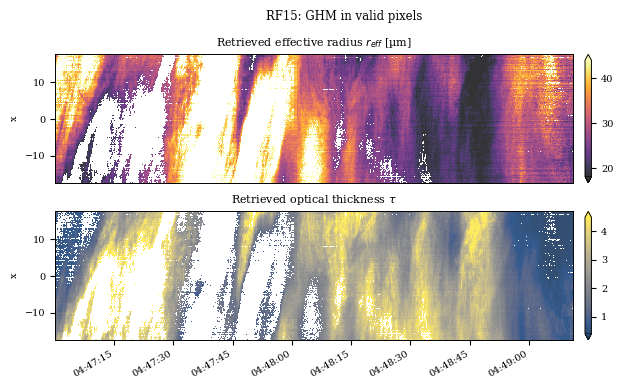

In [225]:
fig, ax = plt.subplots(nrows=2, figsize=(1.1*textwidth, textwidth/gr), sharex=True)
alpha=0.8

plot_cloud_properties = cloud_properties_rough.sel(ic_habit='ghm').rolling(x=2, time=2).mean().where(unambig.r_eff.notnull())

plot_cloud_properties.r_eff.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[0], cmap='inferno', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[0].set_xlabel('')
ax[0].set_title(r"Retrieved effective radius $r_{eff}$ [µm]")

plot_cloud_properties.tau550.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[1], cmap='cividis', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[1].set_xlabel('')
ax[1].set_title(r"Retrieved optical thickness $\tau$")

for axis in ax:
    axis.set_ylabel('x')

ax[0].tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

fig.suptitle("RF15: GHM in valid pixels")
#plt.suptitle("Bispectral retrieval results with GHM assumption")
plt.tight_layout()

commit("RF15_cloud_properties_ghm_selected.png")

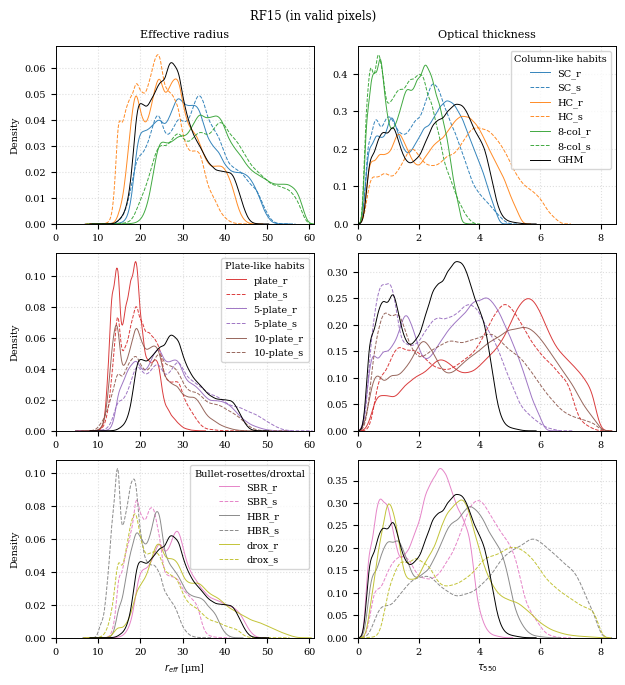

In [227]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(textwidth, textwidth*1.1))

ax = axes[0,:]
color_counter=0
for habit in column_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}")
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}")
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').where(unambig.r_eff.notnull()).values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').where(unambig.r_eff.notnull()).values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")

ax[1].set_ylabel(None)
ax[1].legend(title="Column-like habits")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')

ax[0].set_title(r"Effective radius", fontsize=8)
ax[1].set_title(r"Optical thickness", fontsize=8)

ax = axes[1,:]
for habit in plate_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}", label=name_dict_rough[habit])
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}", label=name_dict_smooth[habit])
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').where(unambig.r_eff.notnull()).values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').where(unambig.r_eff.notnull()).values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")


ax[1].set_ylabel(None)
ax[0].legend(title="Plate-like habits")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')
    

ax = axes[2,:]
for habit in bullet_rosette_and_droxtal_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}", label=name_dict_rough[habit])
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}", label=name_dict_smooth[habit])
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).where(unambig.r_eff.notnull()).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').where(unambig.r_eff.notnull()).values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').where(unambig.r_eff.notnull()).values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")

ax[1].set_ylabel(None)
ax[0].legend(title="Bullet-rosettes/droxtal")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')

ax[0].set_xlabel(r"$r_{eff}$ [µm]")
ax[1].set_xlabel(r"$\tau_{550}$")

for panel in axes[:,0]:
    panel.set_xlim((0,61))
for panel in axes[:,1]:
    panel.set_xlim((0,8.5))

fig.suptitle(r"RF15 (in valid pixels)")
plt.tight_layout()
commit("RF15_all_hists_selected.png")

In [335]:
for habit in cloud_properties_rough.ic_habit:
    selection = cloud_properties_rough.sel(ic_habit=habit).rolling(x=2, time=2).mean().where(unambig.r_eff.notnull())
    coeff = xr.corr(selection.r_eff, selection.tau550)
    
    print(f"Habit: {iceMACS.name_dict_rough[habit.values.item()]}: {coeff.values.item()}")

Habit: 8-col_r: -0.5577644130639557
Habit: drox_r: -0.7163601145124913
Habit: GHM: -0.6246417756302213
Habit: HBR_r: -0.6095513923085548
Habit: HC_r: -0.658779007179588
Habit: plate_r: -0.625402984151697
Habit: 10-plate_r: -0.7270397198581044
Habit: 5-plate_r: -0.7089833281184229
Habit: SBR_r: -0.5387651451625217
Habit: SC_r: -0.6480539738998566


In [336]:
for habit in cloud_properties_smooth.ic_habit:
    selection = cloud_properties_smooth.sel(ic_habit=habit).rolling(x=2, time=2).mean().where(unambig.r_eff.notnull())
    coeff = xr.corr(selection.r_eff, selection.tau550)
    
    print(f"Habit: {iceMACS.name_dict_smooth[habit.values.item()]}: {coeff.values.item()}")

Habit: 8-col_s: -0.5910302477207603
Habit: drox_s: -0.718933815516566
Habit: HBR_s: -0.6159190841514374
Habit: HC_s: -0.6754260949794789
Habit: plate_s: -0.6051049327179309
Habit: 10-plate_s: -0.7125714578855442
Habit: 5-plate_s: -0.7054325322047216
Habit: SBR_s: -0.5538813278848027
Habit: SC_s: -0.626588832971779


In [519]:
r_slice_ghm = cloud_properties_rough.isel(x=slice(158, 161)).mean(dim='x').sel(ic_habit='ghm').r_eff
absolute_errors_ghm = r_slice_ghm.copy()

filled_cloud_properties_ghm = r_slice_ghm.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_ghm = filled_cloud_properties_ghm.sel(time=t).values.item()
    rel_error_ghm = r_relative_error_function.interp(r_eff=r_eff_ghm).values.item()
    absolute_errors_ghm.loc[dict(time=t)] = r_eff_ghm*rel_error_ghm
    
    
r_slice_plate_smooth = cloud_properties_smooth.sel(ic_habit='plate').isel(x=slice(158, 161)).mean(dim='x').r_eff
absolute_errors_plate_smooth = r_slice_plate_smooth.copy()

filled_cloud_properties_plate_smooth = r_slice_plate_smooth.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_plate_smooth = filled_cloud_properties_plate_smooth.sel(time=t).values.item()
    rel_error_plate_smooth = r_relative_error_function.interp(r_eff=r_eff_plate_smooth).values.item()
    absolute_errors_plate_smooth.loc[dict(time=t)] = r_eff_plate_smooth*rel_error_plate_smooth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3894/3894 [00:15<00:00, 257.94it/s]


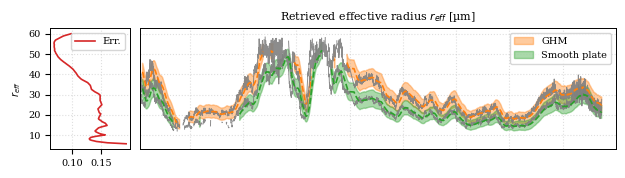

In [521]:
fig, axes = plt.subplots(ncols=2, figsize=(textwidth, textwidth/3.5), gridspec_kw={'width_ratios': [1, 6]}, sharey=True)

ax = axes[0]
r_relative_error_function.plot(ax=ax, y='r_eff', linewidth=1.2, color='tab:red', label="Err.")

ax.grid(alpha=0.4, linestyle='dotted')
ax.set_title(None)
ax.set_xlabel(None)
ax.set_ylabel(r"$r_{eff}$")
ax.legend(loc='upper right')
ax=axes[1]

color='C1'
upper_ghm =  (absolute_errors_ghm+r_slice_ghm).rolling(time=50).mean().values
lower_ghm =  (r_slice_ghm-absolute_errors_ghm).rolling(time=50).mean().values
ax.fill_between(r_slice_ghm.time.values, upper_ghm, lower_ghm, alpha=0.4, color=color, label="GHM")

r_slice_ghm.plot(alpha=0.9, color='gray', ax=ax)

r_slice_ghm.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)


color='C2'
upper_plate_smooth =  (absolute_errors_plate_smooth+r_slice_plate_smooth).rolling(time=50).mean().values
lower_plate_smooth =  (r_slice_plate_smooth-absolute_errors_plate_smooth).rolling(time=50).mean().values
ax.fill_between(r_slice_plate_smooth.time.values, upper_plate_smooth, lower_plate_smooth, alpha=0.4, color=color, label='Smooth plate')

r_slice_plate_smooth.plot(alpha=0.9, color='gray', ax=ax)
r_slice_plate_smooth.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)

ax.tick_params(axis='y', which='both',
               left=False, labelleft=False)
ax.set_ylabel(None)
ax.set_xlabel(None)
# ax.set_ylim((13, 40))
ax.set_title(None)
ax.set_xlim((datetime.datetime(2022, 4, 8, 4, 47, 1), datetime.datetime(2022, 4, 8, 4, 49, 15)))
ax.legend()
ax.grid(alpha=0.4, linestyle='dotted')
ax.tick_params(axis='x', which='both',
               bottom=False, labelbottom=False)
ax.set_title(r"Retrieved effective radius $r_{eff}$ [µm]", fontsize=8)
plt.tight_layout()

commit("RF15_effective_radius_temporal.png")

In [522]:
r_slice_ghm = cloud_properties_rough.isel(x=slice(158, 161)).mean(dim='x').sel(ic_habit='ghm').tau550
absolute_errors_ghm = r_slice_ghm.copy()

filled_cloud_properties_ghm = r_slice_ghm.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_ghm = filled_cloud_properties_ghm.sel(time=t).values.item()
    rel_error_ghm = tau_relative_error_function.interp(tau550=r_eff_ghm).values.item()
    absolute_errors_ghm.loc[dict(time=t)] = r_eff_ghm*rel_error_ghm
    
    
r_slice_plate_smooth = cloud_properties_smooth.sel(ic_habit='plate').isel(x=slice(158, 161)).mean(dim='x').tau550
absolute_errors_plate_smooth = r_slice_plate_smooth.copy()

filled_cloud_properties_plate_smooth = r_slice_plate_smooth.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_plate_smooth = filled_cloud_properties_plate_smooth.sel(time=t).values.item()
    rel_error_plate_smooth = tau_relative_error_function.interp(tau550=r_eff_plate_smooth).values.item()
    absolute_errors_plate_smooth.loc[dict(time=t)] = r_eff_plate_smooth*rel_error_plate_smooth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3894/3894 [00:16<00:00, 234.13it/s]


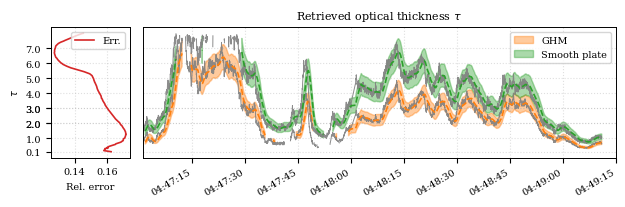

In [523]:
fig, axes = plt.subplots(ncols=2, figsize=(textwidth, textwidth/3), gridspec_kw={'width_ratios': [1, 6]}, sharey=True)

ax = axes[0]
tau_relative_error_function.plot(ax=ax, y='tau550', linewidth=1.2, color='tab:red', label='Err.')

ax.grid(alpha=0.4, linestyle='dotted')
ax.set_title(None)
ax.set_xlabel("Rel. error")
ax.set_ylabel(r"$\tau$")
ax.set_yticks([0.1, 1.0, 2.0, 3.0, 2, 3, 4, 5, 6, 7])
ax.legend(loc='upper right')
ax=axes[1]

color='C1'
upper_ghm =  (absolute_errors_ghm+r_slice_ghm).rolling(time=50).mean().values
lower_ghm =  (r_slice_ghm-absolute_errors_ghm).rolling(time=50).mean().values
ax.fill_between(r_slice_ghm.time.values, upper_ghm, lower_ghm, alpha=0.4, color=color, label="GHM")

r_slice_ghm.plot(alpha=0.9, color='gray', ax=ax)

r_slice_ghm.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)


color='C2'
upper_plate_smooth =  (absolute_errors_plate_smooth+r_slice_plate_smooth).rolling(time=50).mean().values
lower_plate_smooth =  (r_slice_plate_smooth-absolute_errors_plate_smooth).rolling(time=50).mean().values
ax.fill_between(r_slice_plate_smooth.time.values, upper_plate_smooth, lower_plate_smooth, alpha=0.4, color=color, label='Smooth plate')

r_slice_plate_smooth.plot(alpha=0.9, color='gray', ax=ax)
r_slice_plate_smooth.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)

ax.tick_params(axis='y', which='both',
               left=False, labelleft=False)
ax.set_ylabel(None)
ax.set_xlabel(None)
#ax.set_ylim((0, 7))
ax.set_title(None)
ax.set_xlim((datetime.datetime(2022, 4, 8, 4, 47, 1), datetime.datetime(2022, 4, 8, 4, 49, 15)))
ax.legend()
ax.grid(alpha=0.4, linestyle='dotted')

ax.set_title(r"Retrieved optical thickness $\tau$", fontsize=8)
plt.tight_layout()

commit("RF15_tau_temporal.png")

## RF03

In [4]:
swir_scene = iceMACS.read_LUT('../scenes/MWAI_RF03/data/swir_scene.nc')
solar_positions = iceMACS.read_LUT('../scenes/MWAI_RF03/data/solar_positions.nc')
cloud_properties = iceMACS.read_LUT('../scenes/MWAI_RF03/data/cloud_properties_ghm.nc')
view_angles = iceMACS.read_LUT('../scenes/MWAI_RF03/data/view_angles.nc')

In [5]:
view_angles = iceMACS.read_LUT('../scenes/MWAI_RF03/data/view_angles.nc')
swir_scene = iceMACS.read_LUT('../scenes/MWAI_RF03/data/swir_scene.nc')
solar_positions = iceMACS.read_LUT('../scenes/MWAI_RF03/data/solar_positions.nc')

from iceMACS.tools import PixelInterpolator
interp = PixelInterpolator(swir_scene, window=2)
interp.add_cutoffs([2, 3, 0.2, 2])

filtered_swir_scene = swir_scene.copy()
filtered_swir_scene['radiance'] = interp.filtered_radiance(remove=True)

from iceMACS.tools import SceneInterpreter
scene = SceneInterpreter(filtered_swir_scene, view_angles, solar_positions)

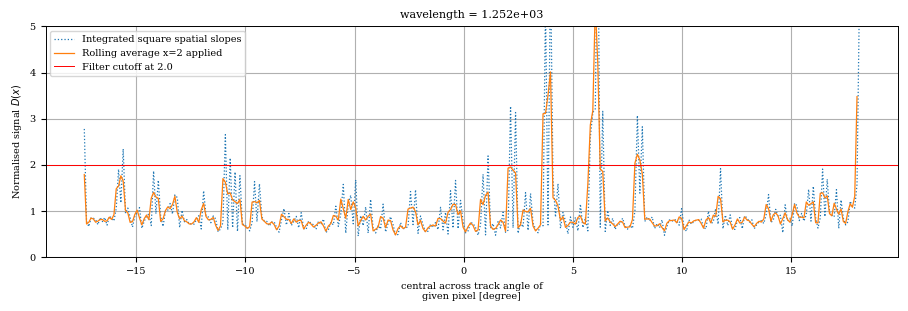

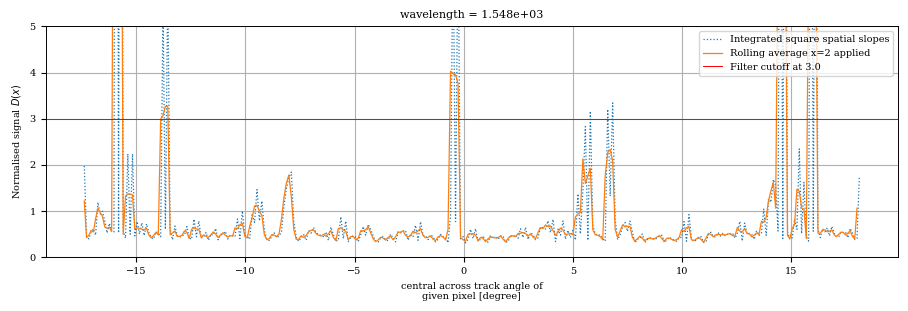

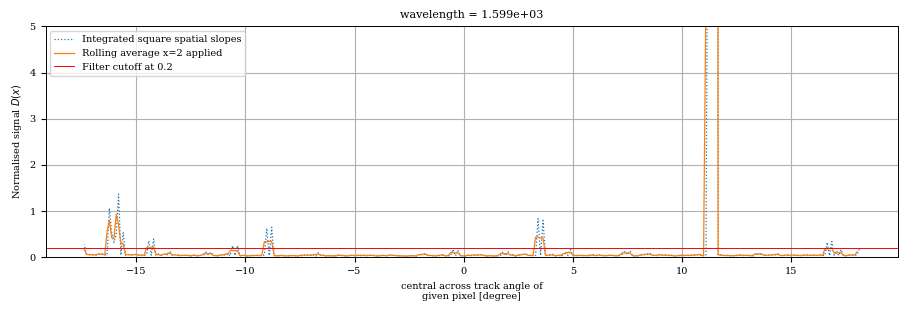

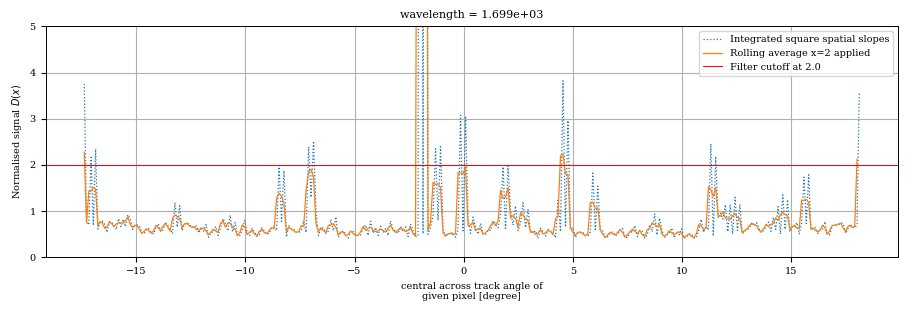

In [6]:
interp.show_signals()

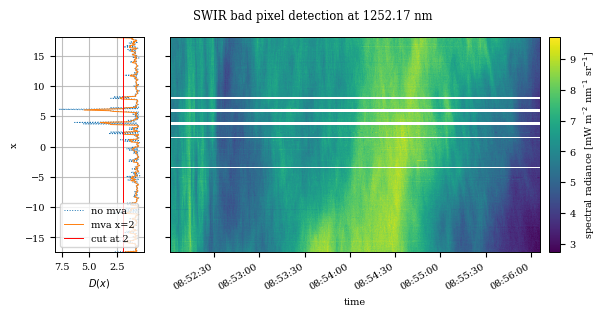

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(textwidth, textwidth/2), gridspec_kw={'width_ratios': [1, 5]}, sharey=True)
wvl=1250

data_sel = interp.data.sel(wavelength=wvl, method='nearest')
data_sel.int_slopes.plot(y='x', linestyle='dotted', label='no mva', ax=ax[0])
data_sel.int_slopes_mva.plot(y='x', label=f"mva x={interp.window}", ax=ax[0])
ax[0].set_xlabel(r'$D(x)$')
#ax[0].set_title(f"SWIR invalid pixel detection at {data_sel.wavelength.values.item():.2f}nm channel")
ax[0].axvline(interp.cutoffs[0], color='red', label=f"cut at {interp.cutoffs[0]}")
#plt.yscale('log')
ax[0].grid(alpha=0.8)
ax[0].set_xlim((ax[0].get_xlim()[1], ax[0].get_xlim()[0]))
ax[0].set_title('')
ax[0].set_ylabel('x')
interp.filtered_radiance(remove=True).sel(wavelength=wvl, method='nearest').plot(ax=ax[1], x='time', cbar_kwargs={'label':r"spectral radiance [mW m$^{⁻2}$ nm$^{⁻1}$ sr$^{-1}$]" ,'pad':0.02})
ax[0].legend(loc='lower left')
ax[1].set_title('')
ax[1].set_ylabel("")
ax[1].tick_params(axis='y', which='both', bottom=False, top=False, labelleft=False)

plt.suptitle("SWIR bad pixel detection at 1252.17 nm")
plt.tight_layout()
#commit("filter_threshold_demo.png")

In [8]:
filtered_swir_scene = swir_scene.copy()
filtered_swir_scene['radiance'] = interp.filtered_radiance(remove=True)

from iceMACS.tools import SceneInterpreter
scene = SceneInterpreter(filtered_swir_scene, view_angles, solar_positions)

In [9]:
import datetime
start_time = swir_scene.time[0]
end_time = datetime.datetime(2022, 3, 13, 8, 56, 5)
RF03_wales = iceMACS.read_LUT("/project/meteo/work/Veronika.Poertge/for_dennys/WALES_Daten/20220313/HALO-AC3_HALO_WALES_bsrgl_20220313_RF03_V2.0.nc")

In [10]:
RF03_wales

<xarray.Dataset>
Dimensions:                (time: 28499, altitude: 917)
Coordinates:
  * time                   (time) datetime64[ns] 2022-03-13T08:35:01.18997939...
    latitude               (time) float64 ...
    longitude              (time) float64 ...
  * altitude               (altitude) float32 1.324e+04 1.323e+04 ... -488.3
Data variables:
    backscatter_ratio      (time, altitude) float32 ...
    flags                  (time, altitude) int16 ...
    error                  (time, altitude) float32 ...
    vertical_resolution    (altitude) float32 ...
    flight_altitude        (time) float32 ...
    off_nadir_angle        (time) float64 ...
    horizontal_resolution  (time) float32 ...
    airdensity             (time, altitude) float32 ...
    airtemperature         (time, altitude) float32 ...
Attributes: (12/31)
    convention:            CF-1.8
    title:                 WALES L1
    data_version:          2.0
    featureType:           trajectory
    author:                Martin Wirth
    contact:               martin.wirth@dlr.de
    ...                    ...
    ongoing_subset:        3
    sigmartotal:           5.233e-31
    main_quantity_name:    backscatter_ratio
    wavelength:            532.0097531947728
    polarisation:          unpolarised
    rho_to_betar:          6.2464336e-32

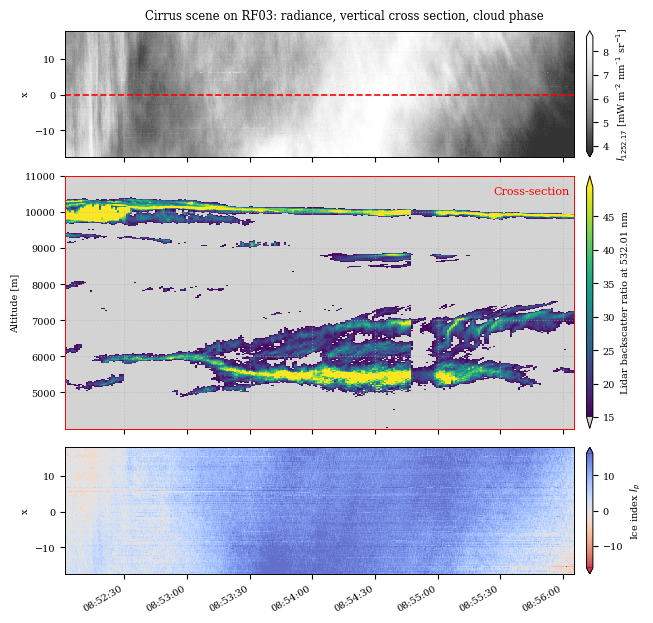

In [11]:
fig, ax = plt.subplots(nrows=3, figsize=(1.1*textwidth, textwidth), gridspec_kw={'height_ratios': [1, 2, 1]}, sharex=True)
alpha=0.8

filtered_swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[0], 
                                                                                           cmap='Greys_r', cbar_kwargs={'label':r"$I_{1252.17}$ [mW m$^{⁻2}$ nm$^{⁻1}$ sr$^{-1}$]" ,'pad':0.02}, alpha=alpha)
scene.ice_index_Jaekel2013().dropna(dim='x', how='all').rolling(x=2, time=2).mean().plot(x='time', robust=True, ax=ax[2], cbar_kwargs={'label':r"Ice index $I_p$" ,'pad':0.02}, alpha=alpha, cmap='coolwarm_r')
ax[2].set_xlabel('')
ax[2].set_title(None)

for axis in ax:
    axis.set_ylabel('x')
    
# ax[0].tick_params(axis='x', which='both', bottom=False,
#                 top=False, labelbottom=False)
# ax[1].tick_params(axis='x', which='both', bottom=False,
#                 top=False, labelbottom=False)

x_values = view_angles.vza.x.values

# Initialize an empty array to store the x coordinate where vza is closest to 0
closest_to_0_x = []

# Loop through each time step to find the x coordinate closest to 0 for vza
for time_idx in range(len(view_angles.vza.time)):
    vza_time = view_angles.vza.isel(time=time_idx).values
    idx_closest_to_0 = np.argmin(np.abs(vza_time - 0))
    closest_x = x_values[idx_closest_to_0]
    closest_to_0_x.append(closest_x)

# Convert the result to a numpy array
closest_to_0_x = np.array(closest_to_0_x)


cmap = plt.cm.viridis
cmap.set_under(color='lightgray')

RF03_wales.backscatter_ratio.sel(time=slice(start_time, end_time),
                                 altitude=slice(11000,4000)).plot(y='altitude', vmin=15, cmap=cmap, 
                                                                  robust=True, ax=ax[1], 
                                                                  cbar_kwargs={'label':"Lidar backscatter ratio at 532.01 nm" ,'pad':0.02,
                                                                               'aspect':40})
#plt.clabel(vza.plot.contour(ax=ax[0], x='time', colors='black', linestyle='dashed', levels=5, alpha=0.8), 
 #          inline=True, fontsize=fontsize)

ax[0].set_xlabel('')
ax[0].set_title(None)

ax[1].grid(alpha=0.6, linestyle='dotted')
ax[1].set_xlabel(None)
ax[1].set_ylabel("Altitude [m]")
ax[1].set_title(None)
for spine in ax[1].spines.values():
    spine.set_edgecolor('red')
#ax[0].plot(vza.time, closest_to_0_x, color='orange', linestyle='dashed')
ax[0].axhline(0, color='red', linewidth=1.2, linestyle='dashed')
ax[1].text(datetime.datetime(2022, 3, 13, 8, 55, 45), 10500, "Cross-section", fontsize=8, color='red', horizontalalignment='center')
fig.suptitle("Cirrus scene on RF03: radiance, vertical cross section, cloud phase")
plt.tight_layout()

commit("RF03_overview.png")

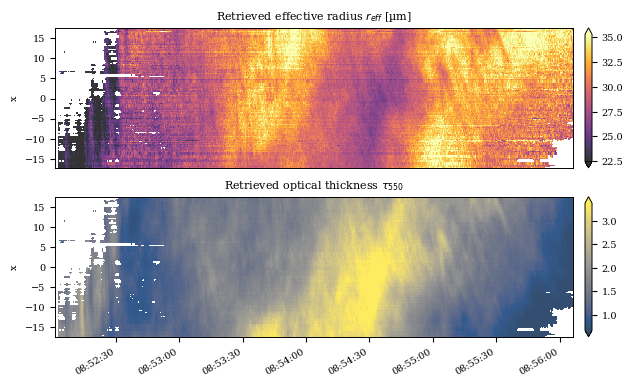

In [12]:
fig, ax = plt.subplots(nrows=2, figsize=(1.1*textwidth, textwidth/gr), sharex=True)
alpha=0.8

plot_cloud_properties = cloud_properties.rolling(x=2, time=2).mean().where(scene.ice_index_Jaekel2013().rolling(x=4, time=50).mean()>1)

plot_cloud_properties.r_eff.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[0], cmap='inferno', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[0].set_xlabel('')
ax[0].set_title(r"Retrieved effective radius $r_{eff}$ [µm]")

plot_cloud_properties.tau550.dropna(dim='x', how='all').plot(x='time', robust=True, ax=ax[1], cmap='cividis', cbar_kwargs={'label':None ,'pad':0.02}, alpha=alpha)
ax[1].set_xlabel('')
ax[1].set_title(r"Retrieved optical thickness $\tau$")

for axis in ax:
    axis.set_ylabel('x')

ax[0].tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

#plt.suptitle("Bispectral retrieval results with GHM assumption")
plt.tight_layout()

commit("cloud_properties_RF03.png")

In [13]:
from iceMACS.tools import BSRLookupTable
LUT = BSRLookupTable.from_path('../scenes/MWAI_RF03/LUTs/final/RF03_ghm_LUT.nc')

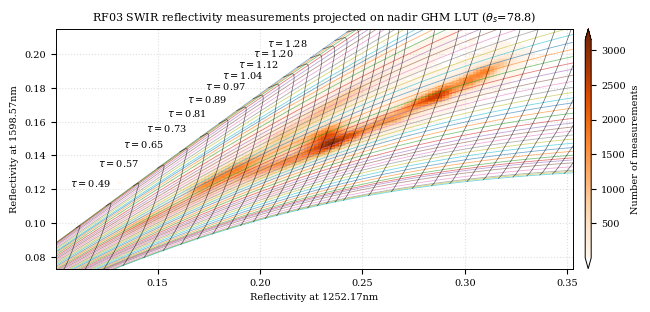

In [14]:
fig, ax = plt.subplots(figsize=(1.1*textwidth, textwidth/2))

LUTcut = LUT.dataset.isel(phi=0, umu=0, sza=0, ic_habit=0).sel(r_eff=LUT.dataset.r_eff[::1], tau550=LUT.dataset.tau550[::1])

#LUTcut_downsampled = LUTcut.sel(r_eff=LUTcut.r_eff[::3], tau550=xr.concat([LUTcut.tau550[0:-1:3], LUTcut.tau550[-1]], dim='tau550'))


LUTcut1 = LUTcut.sel(wvl=LUT.wvl1)
LUTcut2 = LUTcut.sel(wvl=LUT.wvl2)

for r_eff in LUTcut.coords['r_eff'].values:
    ax.plot(LUTcut1.sel(r_eff=r_eff).reflectivity.to_numpy(), 
            LUTcut2.sel(r_eff=r_eff).reflectivity.to_numpy(),
            linewidth=0.6, label=np.round(r_eff, 2), alpha=0.6)

for itau550, tau550 in enumerate(LUTcut.coords['tau550'].values):

    ax.plot(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy(), 
            LUTcut2.sel(tau550=tau550).reflectivity.to_numpy(),
            color="black",
            linewidth=0.5, alpha=0.6)
    
    x = np.max(LUTcut1.sel(tau550=tau550).reflectivity.to_numpy())
    y = np.max(LUTcut2.sel(tau550=tau550).reflectivity.to_numpy())+0.01
    eq = r"$\tau=$"
    
    if tau550>0.41 and tau550<1.36:
        plt.text(x-0.02,y, f"{eq}{tau550:.2f}", fontsize=fontsize, color='black')

cmap = plt.cm.Oranges
cmap.set_under(color='white')

R1 = scene.reflectivity().sel(wavelength=LUT.wvl1, method='nearest').values.flatten()
R2 = scene.reflectivity().sel(wavelength=LUT.wvl2, method='nearest').values.flatten()

valid_indices = np.logical_not(np.logical_or(np.isnan(R1), np.isnan(R2)))
R1_real = R1[valid_indices]
R2_real = R2[valid_indices]

hist = ax.hist2d(R1_real, R2_real, bins=150, vmin=1, cmap=cmap)
plt.colorbar(hist[3], ax=ax, label="Number of measurements", pad=0.02, extend='both', aspect=40)
            
ax.set_xlabel(f"Reflectivity at {LUT.wvl1}nm")
ax.set_ylabel(f"Reflectivity at {LUT.wvl2}nm")
#ax.legend(title=r"Effective radius [$\mu$m]", ncols=3)
theta_s = r"$\theta_s$"
plt.title(f"RF03 SWIR reflectivity measurements projected on nadir GHM LUT ({theta_s}={LUT.dataset.sza.values.item()})")
plt.grid(alpha=0.4, linestyle='dotted')

plt.tight_layout()

commit("RF03_measurements_on_GHMLUT.png")

## RF03 histogram overview

In [15]:
cloud_properties_rough = iceMACS.read_LUT('../scenes/MWAI_RF03/data/merged_cloud_properties_rough.nc').rolling(x=2, time=2).mean().where(scene.ice_index_Jaekel2013().rolling(x=4, time=50).mean()>1)
cloud_properties_smooth = iceMACS.read_LUT('../scenes/MWAI_RF03/data/merged_cloud_properties_smooth.nc').rolling(x=2, time=2).mean().where(scene.ice_index_Jaekel2013().rolling(x=4, time=50).mean()>1)

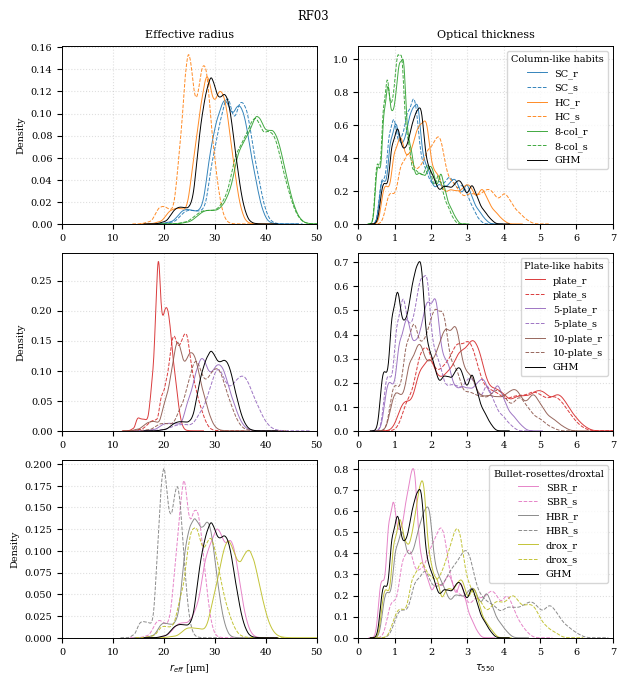

In [16]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(textwidth, textwidth*1.1))

ax = axes[0,:]
color_counter=0
for habit in column_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}")
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}")
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")

ax[1].set_ylabel(None)
ax[1].legend(title="Column-like habits")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')

ax[0].set_title(r"Effective radius", fontsize=8)
ax[1].set_title(r"Optical thickness", fontsize=8)

ax = axes[1,:]
for habit in plate_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}")
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}")
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")


ax[1].set_ylabel(None)
ax[1].legend(title="Plate-like habits")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')
    

ax = axes[2,:]
for habit in bullet_rosette_and_droxtal_habits:
    r_eff_rough_sel = cloud_properties_rough.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_rough_sel, ax=ax[0], alpha=0.9, color=f"C{color_counter}")
    
    r_eff_smooth_sel = cloud_properties_smooth.r_eff.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=r_eff_smooth_sel, ax=ax[0], alpha=0.9, linestyle='dashed', color=f"C{color_counter}")
    
    tau_rough_sel = cloud_properties_rough.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_rough_sel, ax=ax[1], label=name_dict_rough[habit], alpha=0.9, 
                color=f"C{color_counter}")
    
    tau_smooth_sel = cloud_properties_smooth.tau550.sel(ic_habit=habit).values.flatten()
    sns.kdeplot(data=tau_smooth_sel, ax=ax[1], label=name_dict_smooth[habit], alpha=0.9, 
                linestyle='dashed', color=f"C{color_counter}")
    
    color_counter += 1
    
r_eff_ghm = cloud_properties_rough.r_eff.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=r_eff_ghm, ax=ax[0], color='black')

tau_ghm = cloud_properties_rough.tau550.sel(ic_habit='ghm').values.flatten()
sns.kdeplot(data=tau_ghm, ax=ax[1], color='black', label="GHM")

ax[1].set_ylabel(None)
ax[1].legend(title="Bullet-rosettes/droxtal")

for axis in ax:
    axis.grid(alpha=0.4, linestyle='dotted')

ax[0].set_xlabel(r"$r_{eff}$ [µm]")
ax[1].set_xlabel(r"$\tau_{550}$")

for panel in axes[:,0]:
    panel.set_xlim((0,50))
for panel in axes[:,1]:
    panel.set_xlim((0,7))

fig.suptitle(r"RF03")
plt.tight_layout()
commit("RF03_all_hists.png")

In [17]:
r_re_ghm = r_bias_ghm/sensitivity_data_ghm.r_eff
r_re_yang_rough = r_bias_yang_rough/sensitivity_data_yang_rough.r_eff
r_re_yang_smooth = r_bias_yang_smooth/sensitivity_data_yang_smooth.r_eff

tau_re_ghm = tau_bias_ghm/sensitivity_data_ghm.tau550
tau_re_yang_rough = tau_bias_yang_rough/sensitivity_data_yang_rough.tau550
tau_re_yang_smooth = tau_bias_yang_smooth/sensitivity_data_yang_smooth.tau550

r_relative_error_function = (abs(r_re_ghm).mean(dim=("umu", "phi", "tau550")) + abs(r_re_yang_rough).mean(dim=("umu", "phi", "tau550", 'ic_habit')) + abs(r_re_yang_smooth).mean(dim=("umu", "phi", "tau550", 'ic_habit')))/3
tau_relative_error_function = (abs(tau_re_ghm).mean(dim=("umu", "phi", "r_eff")) + abs(tau_re_yang_rough).mean(dim=("umu", "phi", "r_eff", 'ic_habit')) + abs(tau_re_yang_smooth).mean(dim=("umu", "phi", "r_eff", 'ic_habit')))/3

NameError: name 'r_bias_ghm' is not defined

In [23]:
r_slice_ghm = cloud_properties_rough.isel(x=slice(158, 161)).mean(dim='x').sel(ic_habit='ghm').r_eff
absolute_errors_ghm = r_slice_ghm.copy()

filled_cloud_properties_ghm = r_slice_ghm.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_ghm = filled_cloud_properties_ghm.sel(time=t).values.item()
    rel_error_ghm = r_relative_error_function.interp(r_eff=r_eff_ghm).values.item()
    absolute_errors_ghm.loc[dict(time=t)] = r_eff_ghm*rel_error_ghm
    
    
r_slice_plate_smooth = cloud_properties_smooth.sel(ic_habit='plate').isel(x=slice(158, 161)).mean(dim='x').r_eff
absolute_errors_plate_smooth = r_slice_plate_smooth.copy()

filled_cloud_properties_plate_smooth = r_slice_plate_smooth.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_plate_smooth = filled_cloud_properties_plate_smooth.sel(time=t).values.item()
    rel_error_plate_smooth = r_relative_error_function.interp(r_eff=r_eff_plate_smooth).values.item()
    absolute_errors_plate_smooth.loc[dict(time=t)] = r_eff_plate_smooth*rel_error_plate_smooth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7272/7272 [00:33<00:00, 219.18it/s]


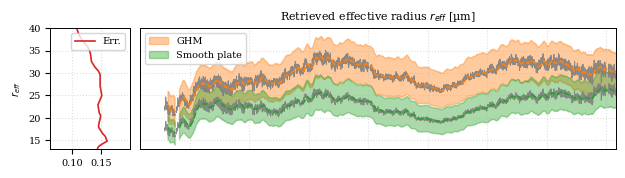

In [26]:
fig, axes = plt.subplots(ncols=2, figsize=(textwidth, textwidth/3.5), gridspec_kw={'width_ratios': [1, 6]}, sharey=True)

ax = axes[0]
r_relative_error_function.plot(ax=ax, y='r_eff', linewidth=1.2, color='tab:red', label="Err.")

ax.grid(alpha=0.4, linestyle='dotted')
ax.set_title(None)
ax.set_xlabel(None)
ax.set_ylabel(r"$r_{eff}$")
ax.legend(loc='upper right')
ax=axes[1]

color='C1'
upper_ghm =  (absolute_errors_ghm+r_slice_ghm).rolling(time=50).mean().values
lower_ghm =  (r_slice_ghm-absolute_errors_ghm).rolling(time=50).mean().values
ax.fill_between(r_slice_ghm.time.values, upper_ghm, lower_ghm, alpha=0.4, color=color, label="GHM")

r_slice_ghm.plot(alpha=0.9, color='gray', ax=ax)

r_slice_ghm.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)


color='C2'
upper_plate_smooth =  (absolute_errors_plate_smooth+r_slice_plate_smooth).rolling(time=50).mean().values
lower_plate_smooth =  (r_slice_plate_smooth-absolute_errors_plate_smooth).rolling(time=50).mean().values
ax.fill_between(r_slice_plate_smooth.time.values, upper_plate_smooth, lower_plate_smooth, alpha=0.4, color=color, label='Smooth plate')

r_slice_plate_smooth.plot(alpha=0.9, color='gray', ax=ax)
r_slice_plate_smooth.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)

ax.tick_params(axis='y', which='both',
               left=False, labelleft=False)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_ylim((13, 40))
ax.set_title(None)
ax.set_xlim((datetime.datetime(2022, 3, 13, 8, 52, 5), datetime.datetime(2022, 3, 13, 8, 56, 5)))
ax.legend()
ax.grid(alpha=0.4, linestyle='dotted')
ax.tick_params(axis='x', which='both',
               bottom=False, labelbottom=False)
ax.set_title(r"Retrieved effective radius $r_{eff}$ [µm]", fontsize=8)
plt.tight_layout()

commit("RF03_effective_radius_temporal.png")

In [27]:
r_slice_ghm = cloud_properties_rough.isel(x=slice(158, 161)).mean(dim='x').sel(ic_habit='ghm').tau550
absolute_errors_ghm = r_slice_ghm.copy()

filled_cloud_properties_ghm = r_slice_ghm.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_ghm = filled_cloud_properties_ghm.sel(time=t).values.item()
    rel_error_ghm = tau_relative_error_function.interp(tau550=r_eff_ghm).values.item()
    absolute_errors_ghm.loc[dict(time=t)] = r_eff_ghm*rel_error_ghm
    
    
r_slice_plate_smooth = cloud_properties_smooth.sel(ic_habit='plate').isel(x=slice(158, 161)).mean(dim='x').tau550
absolute_errors_plate_smooth = r_slice_plate_smooth.copy()

filled_cloud_properties_plate_smooth = r_slice_plate_smooth.fillna(0)
for t in tqdm(cloud_properties_rough.time):
    r_eff_plate_smooth = filled_cloud_properties_plate_smooth.sel(time=t).values.item()
    rel_error_plate_smooth = tau_relative_error_function.interp(tau550=r_eff_plate_smooth).values.item()
    absolute_errors_plate_smooth.loc[dict(time=t)] = r_eff_plate_smooth*rel_error_plate_smooth

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7272/7272 [00:33<00:00, 216.27it/s]


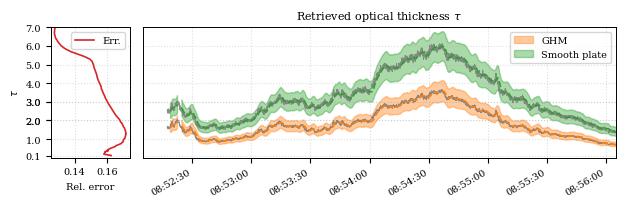

In [29]:
fig, axes = plt.subplots(ncols=2, figsize=(textwidth, textwidth/3), gridspec_kw={'width_ratios': [1, 6]}, sharey=True)

ax = axes[0]
tau_relative_error_function.plot(ax=ax, y='tau550', linewidth=1.2, color='tab:red', label='Err.')

ax.grid(alpha=0.4, linestyle='dotted')
ax.set_title(None)
ax.set_xlabel("Rel. error")
ax.set_ylabel(r"$\tau$")
ax.set_yticks([0.1, 1.0, 2.0, 3.0, 2, 3, 4, 5, 6, 7])
ax.legend(loc='upper right')
ax=axes[1]

color='C1'
upper_ghm =  (absolute_errors_ghm+r_slice_ghm).rolling(time=50).mean().values
lower_ghm =  (r_slice_ghm-absolute_errors_ghm).rolling(time=50).mean().values
ax.fill_between(r_slice_ghm.time.values, upper_ghm, lower_ghm, alpha=0.4, color=color, label="GHM")

r_slice_ghm.plot(alpha=0.9, color='gray', ax=ax)

r_slice_ghm.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)


color='C2'
upper_plate_smooth =  (absolute_errors_plate_smooth+r_slice_plate_smooth).rolling(time=50).mean().values
lower_plate_smooth =  (r_slice_plate_smooth-absolute_errors_plate_smooth).rolling(time=50).mean().values
ax.fill_between(r_slice_plate_smooth.time.values, upper_plate_smooth, lower_plate_smooth, alpha=0.4, color=color, label='Smooth plate')

r_slice_plate_smooth.plot(alpha=0.9, color='gray', ax=ax)
r_slice_plate_smooth.rolling(time=50).mean().plot(color=color, linewidth=1.2, linestyle='dashed', ax=ax)

ax.tick_params(axis='y', which='both',
               left=False, labelleft=False)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_ylim((0, 7))
ax.set_title(None)
ax.set_xlim((datetime.datetime(2022, 3, 13, 8, 52, 5), datetime.datetime(2022, 3, 13, 8, 56, 5)))
ax.legend()
ax.grid(alpha=0.4, linestyle='dotted')

ax.set_title(r"Retrieved optical thickness $\tau$", fontsize=8)
plt.tight_layout()

commit("RF03_tau_temporal.png")

In [ ]:
Ray_reflectivity = Ray_interp.polarized_reflectivity().mean(dim='wvl')

In [ ]:
Ray_reflectivity = Ray_interp.polarized_reflectivity().mean(dim='wvl')

## Habit phase functions

In [288]:
data_5km_noRay_rough = iceMACS.read_LUT("phase_functions_5km_noRay_rough.nc")
data_5km_noRay_smooth = iceMACS.read_LUT("phase_functions_5km_noRay_smooth.nc")

data_5km_rough = iceMACS.read_LUT("phase_functions_5km_rough.nc")
data_5km_smooth = iceMACS.read_LUT("phase_functions_5km_smooth.nc")

data_7km_rough = iceMACS.read_LUT("phase_functions_7km_rough.nc")
data_7km_smooth = iceMACS.read_LUT("phase_functions_7km_smooth.nc")

data_9km_rough = iceMACS.read_LUT("phase_functions_9km_rough.nc")
data_9km_smooth = iceMACS.read_LUT("phase_functions_9km_smooth.nc")

data_11km_rough = iceMACS.read_LUT("phase_functions_11km_rough.nc")
data_11km_smooth = iceMACS.read_LUT("phase_functions_11km_smooth.nc")

data_ocean = iceMACS.read_LUT("BA_only_ocean.nc")
data_rayleigh = iceMACS.read_LUT("BA_only_rayleigh.nc")
data_only_cloud_rough = iceMACS.read_LUT("BA_only_cloud_rough.nc")
data_only_cloud_smooth = iceMACS.read_LUT("BA_only_cloud_smooth.nc")
data_cloud_and_rayleigh_rough = iceMACS.read_LUT("BA_cloud_and_rayleigh_rough.nc")
data_all_rough = iceMACS.read_LUT("BA_all_rough.nc")
data_all_smooth = iceMACS.read_LUT("BA_all_smooth.nc")

solar_flux = iceMACS.tools.solar_flux_kurudz().sel(wavelength=640, method='nearest')

In [166]:
def merge_along_theta(phases):
    
    towards_sun = (phases.sel(phi=180)
                   .assign_coords(umu=(100+np.rad2deg(np.arccos(phases.sel(phi=180).umu))))
                   .rename({'umu':'theta'}))
    
    away_from_sun = (phases.sel(phi=0)
                     .assign_coords(umu=(100-np.rad2deg(np.arccos(phases.sel(phi=0).umu))))
                     .rename({'umu':'theta'}))
    
    phase_functions=xr.concat([away_from_sun.sortby('theta'), towards_sun], dim='theta').sortby('theta')
    
    return phase_functions

In [167]:
pf_5km_noRay_rough = merge_along_theta(data_5km_noRay_rough)
pf_5km_noRay_smooth = merge_along_theta(data_5km_noRay_smooth)

pf_5km_rough = merge_along_theta(data_5km_rough)
pf_5km_smooth = merge_along_theta(data_5km_smooth)

pf_7km_rough = merge_along_theta(data_7km_rough)
pf_7km_smooth = merge_along_theta(data_7km_smooth)

pf_9km_rough = merge_along_theta(data_9km_rough)
pf_9km_smooth = merge_along_theta(data_9km_smooth)

pf_11km_rough = merge_along_theta(data_11km_rough)
pf_11km_smooth = merge_along_theta(data_11km_smooth)


NameError: name 'phase_functions' is not defined

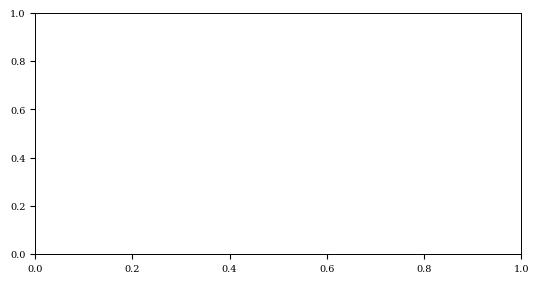

In [286]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth / 2))


color_counter = 0
habit = phase_functions.ic_habit[5]
    
# selected = pf_5km_rough.sel(r_eff=25, tau550=2, ic_habit=habit)
# L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
# L.rolling(theta=3).mean().plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")

    
selected = pf_5km_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed')

selected = pf_7km_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed')

selected = pf_9km_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed')

selected = pf_11km_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed')

ax.grid(alpha=0.4, linestyle='dotted')
plt.legend(ncols=2, title=r"$r_{eff}=25$ µm,  $\tau=2$", loc='upper right')
# plt.xlim((60, 150))
# plt.ylim((0, 0.005))

plt.xlabel(r"Scattering angle $\theta$")
plt.ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title(None)
fig.suptitle("Polarized reflectivity splitting over scattering angle")

#plt.yscale('log')
plt.tight_layout()

#commit("phase_function_splitting_5km.png")
plt.show()

In [289]:
pf_ocean = merge_along_theta(data_ocean)
pf_rayleigh = merge_along_theta(data_rayleigh)
pf_only_cloud_rough = merge_along_theta(data_only_cloud_rough)
pf_only_cloud_smooth = merge_along_theta(data_only_cloud_smooth)
pf_all_rough = merge_along_theta(data_all_rough)
pf_all_smooth = merge_along_theta(data_all_smooth)
pf_cloud_and_rayleigh = merge_along_theta(data_cloud_and_rayleigh_rough)

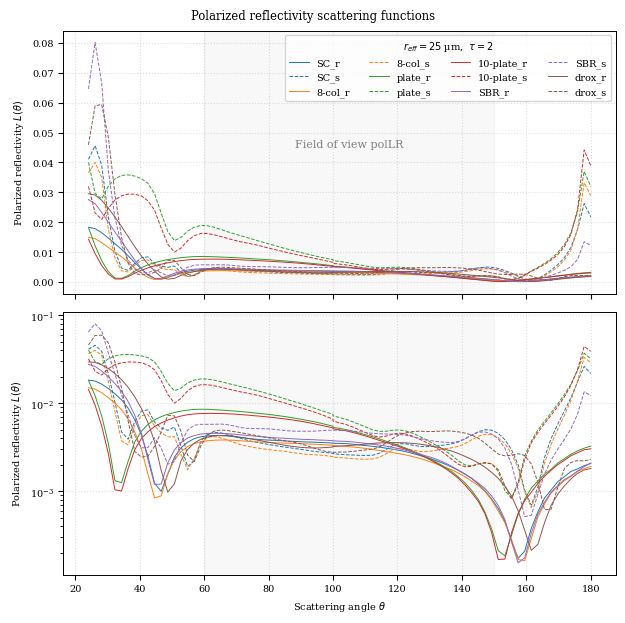

In [294]:
fig, axes = plt.subplots(nrows = 2, figsize=(textwidth, textwidth), sharex=True)

    
#     selected = pf_5km_noRay_rough.sel(r_eff=25, tau550=2, ic_habit=habit)
#     L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
#     L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()])
    
# selected = pf_rayleigh.isel(r_eff=0, tau550=0, ic_habit=0)
# L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
# L.rolling(theta=3).mean().plot(color=f"deepskyblue", alpha=0.8)
    
# selected = pf_ocean.isel(r_eff=0, tau550=0, ic_habit=0)
# L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
# L.rolling(theta=3).mean().plot(color=f"darkblue", alpha=0.8)

ax = axes[0]
color_counter = 0
for habit in pf_only_cloud_rough.ic_habit:
     
    selected = pf_only_cloud_rough.sel(r_eff=25, tau550=2, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}", ax=ax)
    
    selected = pf_only_cloud_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed', ax=ax, color=f"C{color_counter}")
    
    color_counter+=1


ax.legend(ncols=4, title=r"$r_{eff}=25$ µm,  $\tau=2$")
ax.grid(alpha=0.4, linestyle='dotted')
ax.set_xlabel(None)
ax.set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title(None)
ax.axvspan(60, 150, alpha=0.05, color='gray')

ax = axes[1]
color_counter = 0
for habit in pf_only_cloud_rough.ic_habit:
     
    selected = pf_only_cloud_rough.sel(r_eff=25, tau550=2, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")
    
    selected = pf_only_cloud_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed', color=f"C{color_counter}")
    
    color_counter+=1



ax.grid(alpha=0.4, linestyle='dotted')
# plt.xlim((60, 150))
#plt.ylim((0, 0.03))

ax.grid(alpha=0.4, linestyle='dotted')
ax.set_xlabel(r"Scattering angle $\theta$")
ax.set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title(None)
ax.set_yscale('log')
ax.axvspan(60, 150, alpha=0.05, color='gray')
fig.suptitle("Polarized reflectivity scattering functions")
plt.yscale('log')
#plt.ylim((0, 0.035))
# plt.text(80, 0.015, "Subvisual cloud + ocean BPDF + atmospheric background", color='deepskyblue')
# plt.text(90, 0.0005, "Subvisual cloud + ocean BPDF", color='darkblue')

axes[0].text(105, 0.045, "Field of view polLR", horizontalalignment='center', color='gray', fontsize=8)
plt.tight_layout()

commit("phase_function_splitting_5km.png")
plt.show()

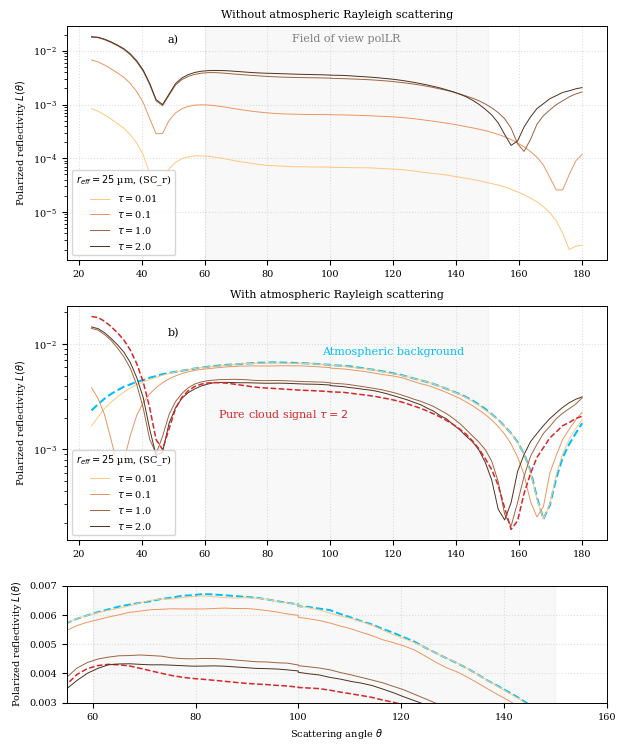

In [392]:
fig, axes = plt.subplots(nrows = 3, figsize=(textwidth, 1.2*textwidth), gridspec_kw={'height_ratios': [1, 1, 0.5]}, sharex=False)

cmap=matplotlib.cm.copper_r
ax = axes[0]
    
for index, tau in enumerate(pf_only_cloud_rough.tau550):
    selected = pf_only_cloud_rough.sel(r_eff=25, tau550=tau, ic_habit="solid_column")
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=r"$\tau =$" + str(tau.values.item()), ax=ax, color=cmap(index/4))


ax.legend(title=r"$r_{eff}=25$ µm, (SC_r)", loc='lower left')
ax.grid(alpha=0.4, linestyle='dotted')
ax.set_xlabel(None)
ax.set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title("Without atmospheric Rayleigh scattering")
ax.axvspan(60, 150, alpha=0.05, color='gray')
ax.set_yscale("log")

ax = axes[1]

selected = pf_rayleigh.sel(r_eff=25, tau550=2).isel(ic_habit=0)
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(ax=ax, color="deepskyblue", linewidth=1.5, linestyle='dashed')
    
for index, tau in enumerate(pf_only_cloud_rough.tau550):
    selected = pf_cloud_and_rayleigh.sel(r_eff=25, tau550=tau, ic_habit="solid_column")
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=r"$\tau =$" + str(tau.values.item()), ax=ax, color=cmap(index/4))

selected = pf_only_cloud_rough.sel(r_eff=25, tau550=2, ic_habit="solid_column")
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(ax=ax, color='tab:red', linewidth=1.1, linestyle='dashed')
L.rolling(theta=3).mean().plot(ax=axes[2], color='tab:red', linewidth=1.1, linestyle='dashed')
    
ax.legend(title=r"$r_{eff}=25$ µm, (SC_r)", loc='lower left')
ax.grid(alpha=0.4, linestyle='dotted')
ax.set_xlabel(None)
ax.set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title("With atmospheric Rayleigh scattering")
ax.axvspan(60, 150, alpha=0.05, color='gray')
ax.set_yscale("log")
ax.set_xlabel(None)
#ax.set_ylim((0.001, 0.007))


ax = axes[2]

selected = pf_rayleigh.sel(r_eff=25, tau550=2).isel(ic_habit=0)
L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
L.rolling(theta=3).mean().plot(ax=ax, color="deepskyblue", linewidth=1.4, linestyle='dashed')
    
for index, tau in enumerate(pf_only_cloud_rough.tau550):
    selected = pf_cloud_and_rayleigh.sel(r_eff=25, tau550=tau, ic_habit="solid_column")
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=r"$\tau =$" + str(tau.values.item()), ax=ax, color=cmap(index/4))

ax.grid(alpha=0.4, linestyle='dotted')
ax.set_xlabel(None)
ax.set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title(None)
ax.axvspan(60, 150, alpha=0.05, color='gray')
#ax.set_yscale("log")
ax.set_xlabel(r"Scattering angle $\theta$")
ax.set_ylim((0.003, 0.007))
ax.set_xlim((55, 160))


axes[0].text(50, 0.014, "a)", horizontalalignment='center', fontsize=fontsize+1)
axes[1].text(50, 0.012, "b)", horizontalalignment='center', fontsize=fontsize+1)
axes[1].text(120, 0.008, "Atmospheric background", horizontalalignment='center', fontsize=fontsize+1, color="deepskyblue")
axes[1].text(85, 0.002, r"Pure cloud signal $\tau=2$", horizontalalignment='center', fontsize=fontsize+1, color="tab:red")
axes[0].text(105, 0.015, "Field of view polLR", horizontalalignment='center', color='gray', fontsize=8)
plt.tight_layout()

commit("phase_function_splitting_with_Rayleigh.png")
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth / 2))


color_counter = 0
for habit in phase_functions.ic_habit:
    
#     selected = pf_5km_noRay_rough.sel(r_eff=25, tau550=2, ic_habit=habit)
#     L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
#     L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()])
    
    selected = pf_5km_rough.sel(r_eff=25, tau550=0.01, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(color=f"deepskyblue", alpha=0.8)
    selected = pf_5km_smooth.sel(r_eff=25, tau550=0.01, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(color=f"deepskyblue", alpha=0.8)
    
    
    selected = pf_5km_rough.sel(r_eff=25, tau550=2, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=name_dict_rough[habit.values.item()], color=f"C{color_counter}")
    
    selected = pf_5km_smooth.sel(r_eff=25, tau550=2, ic_habit=habit)
    L = np.sqrt(np.square(selected.Q) + np.square(selected.U))/(solar_flux*np.cos(np.deg2rad(80)))
    L.rolling(theta=3).mean().plot(label=name_dict_smooth[habit.values.item()], linestyle='dashed', color=f"C{color_counter}")
    
    color_counter+=1

ax.grid(alpha=0.4, linestyle='dotted')
plt.legend(ncols=2, title=r"$r_{eff}=25$ µm,  $\tau=2$", loc='upper right')
# plt.xlim((60, 150))
plt.ylim((0, 0.03))

plt.xlabel(r"Scattering angle $\theta$")
plt.ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title(None)
fig.suptitle("Polarized reflectivity splitting over scattering angle")

plt.text(100, 0.011, "Ocean BPDF and atmospheric background", color='deepskyblue')
plt.tight_layout()

commit("phase_function_splitting_5km.png")
plt.show()

## RF15 Angular retrieval demo

In [347]:
view_angles = iceMACS.read_LUT('../scenes/polar_low_RF15/data/view_angles.nc')
swir_scene = iceMACS.read_LUT('../scenes/polar_low_RF15/data/RF15_swir_scene.nc')
solar_positions = iceMACS.read_LUT('../scenes/polar_low_RF15/data/solar_positions.nc')
nas_scene = iceMACS.read_LUT('../scenes/polar_low_RF15/data/nas_scene.nc')

In [348]:
pol = iceMACS.read_LUT('/scratch/v/Veronika.Poertge/ac3/cloudbow_retrieval_results_0_height_offset/concatenated_dennys_1_polb_with_latlonheight_with_viewing_angle.nc')
pol = pol.sel(color=0)

pol_ds = pol.sel(sample=pol.sample[::10])

inflight_B = iceMACS.read_LUT('../mystic_tests/calibration_files/specMACS_POLB_cal_CHB2021+inflight.nc')
swir_coords = iceMACS.read_LUT('/project/meteo/work/Weber.Ann/PhD/swir_phase/coords3D/swir_3D_coords_latlonheight_from_polcam_samples_2022-04-08T04:46:01_2022-04-08T04:48:59.nc')

cloud_properties_rough = iceMACS.read_LUT('../scenes/polar_low_RF15/data/RF15_merged_cloud_properties_rough.nc').rolling(x=2, time=20).mean().interp(time=swir_scene.time)
cloud_properties_smooth = iceMACS.read_LUT('../scenes/polar_low_RF15/data/RF15_merged_cloud_properties_smooth.nc').rolling(x=2, time=20).mean().interp(time=swir_scene.time)

In [349]:
from iceMACS.tools import PolSceneInterpreter
pol_scene = PolSceneInterpreter(pol, nas_scene, solar_positions)

In [350]:
sim_formatted_smooth = iceMACS.read_LUT('../scenes/polar_low_RF15/data/sim_formatted_smooth.nc')
sim_formatted_rough = iceMACS.read_LUT('../scenes/polar_low_RF15/data/sim_formatted_rough.nc')
swir_sample_coordinates = iceMACS.read_LUT('../scenes/polar_low_RF15/data/swir_sample_coordinates.nc')#.where(sim_formatted_rough != np.nan)

In [351]:
absolute_signal_rough = sim_formatted_rough.simulated_reflectivity.where(sim_formatted_rough.r_eff<60.)
absolute_signal_smooth = sim_formatted_smooth.simulated_reflectivity.where(sim_formatted_smooth.r_eff<60.)

unambig = 1
for habit in absolute_signal_rough.ic_habit:
    unambig = unambig*absolute_signal_rough.sel(ic_habit=habit).mean(dim='theta_mean')
    
for habit in absolute_signal_smooth.ic_habit:
    unambig = unambig*absolute_signal_smooth.sel(ic_habit=habit).mean(dim='theta_mean')

relative_signal_rough = absolute_signal_rough/absolute_signal_rough.mean(dim='theta_mean', skipna=True).where(unambig.notnull())
relative_signal_smooth = absolute_signal_smooth/absolute_signal_smooth.mean(dim='theta_mean', skipna=True).where(unambig.notnull())

absolute_measured_reflectivity = pol_scene.polarized_reflectivity(inflight_B).sel(color='red', sample=pol_ds.sample).where(unambig.notnull())
relative_measured_reflectivity = (absolute_measured_reflectivity/absolute_measured_reflectivity.mean(dim="theta_mean", skipna=True))

In [368]:
height_interp = swir_coords.interp(time=cloud_properties_rough.time).height
plot_height = height_interp.sel(time=slice(height_interp.time[0], swir_coords.time[-1]))

In [402]:
nas_scene.height.interp(time=plot_height.time).mean()

<xarray.DataArray 'height' ()>
array(10280.37793582)
Coordinates:
    sza      float64 83.69

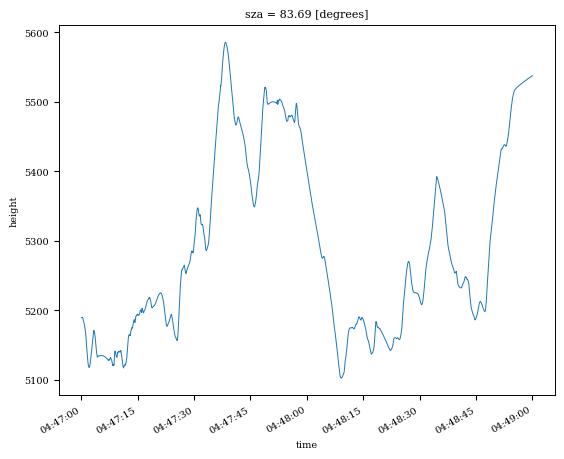

In [400]:
(nas_scene.height.interp(time=plot_height.time) - plot_height.mean(dim='x')).plot()

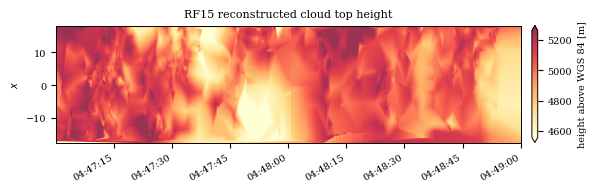

In [396]:
fig, axes = plt.subplots(figsize=(textwidth, textwidth/(2*gr)))

ax = axes
plot_height.plot(robust=True, ax=ax, cbar_kwargs={'label':"height above WGS 84 [m]",'pad':0.02}, cmap="YlOrRd", alpha=0.8)

ax.set_ylabel(r"$x$")
ax.set_xlabel(None)
ax.set_title("RF15 reconstructed cloud top height", fontsize=fontsize+1)

plt.tight_layout()

commit("RF15_cloud_top_height.png")

In [198]:
theta_grid = relative_measured_reflectivity.theta_mean
mean_angles = (swir_sample_coordinates.swir_x.copy()*np.nan).rename('average_theta')
number_of_angles = (swir_sample_coordinates.swir_x.copy()*np.nan).rename('number_of_angles')
scattering_angles = np.ones(len(all_diffs.ic_habit))

for sample in relative_measured_reflectivity.sample:
    
    valid_theta_positions = relative_measured_reflectivity.sel(sample=sample).notnull()
    valid_angles = theta_grid.where(valid_theta_positions)
    
    mean_angles.loc[sample]=valid_angles.mean().values.item()
    number_of_angles.loc[sample]=valid_theta_positions.sum()
    #relative_measured_reflectivity.sel(sample=sample).sel(theta_mean=valid_angles.dropna(dim='theta_mean')).plot()

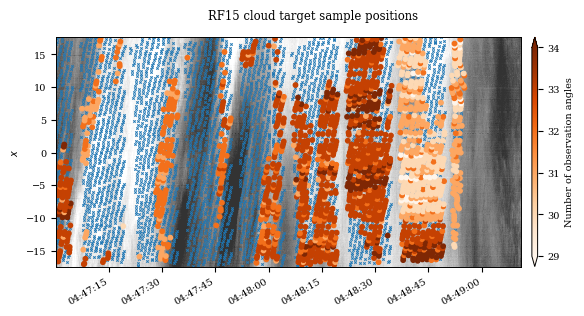

In [210]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth / 2))
swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.8, ax=ax)

plt.scatter(swir_sample_coordinates.swir_time.values, 
            swir_sample_coordinates.swir_x.values,
            color='tab:blue', marker='x', s=3)

scatter = plt.scatter(swir_sample_coordinates.swir_time.values, 
            swir_sample_coordinates.swir_x.values,
            c=number_of_angles, s=10*best_depths/best_depths, cmap='Oranges')
plt.colorbar(scatter, label="Number of observation angles", pad=0.02, extend='both', aspect=40)

plt.ylabel(r"$x$")
plt.xlabel(None)
ax.set_title(None)
fig.suptitle("RF15 cloud target sample positions")
plt.tight_layout()
commit("RF15_targets_on_cloud.png")
plt.show()

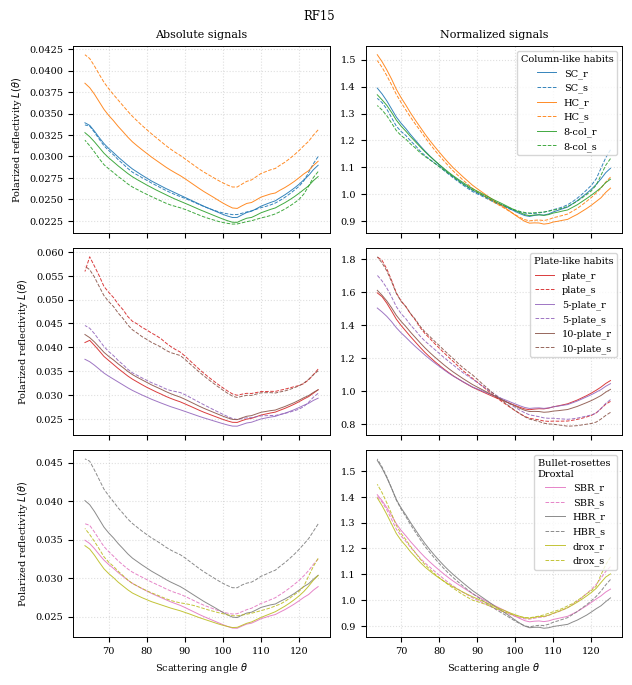

In [209]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(textwidth, textwidth*1.1), sharex=True)

color_counter=0
ax = axes[0,:]
for habit in column_habits:
    
    #absolutes 
    (absolute_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (absolute_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    #relatives
    (relative_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (relative_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    color_counter += 1

ax[1].legend(title="Column-like habits", loc='upper right')
ax[0].set_xlabel(None)
ax[0].set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[0].set_title("Absolute signals")
ax[1].set_title("Normalized signals")


ax = axes[1,:]
for habit in plate_habits:
    
    #absolutes 
    (absolute_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], label=name_dict_rough[habit], color=f"C{color_counter}", alpha=0.9)
    
    (absolute_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], linestyle='dashed', label=name_dict_smooth[habit], alpha=0.9, color=f"C{color_counter}")
    
    #relatives
    (relative_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (relative_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], linestyle='dashed', label=name_dict_smooth[habit], alpha=0.9, color=f"C{color_counter}")
    
    color_counter += 1

ax[1].legend(title="Plate-like habits", loc='upper right')
ax[0].set_xlabel(None)
ax[0].set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[0].set_title(None)
ax[1].set_title(None)


ax = axes[2,:]
for habit in bullet_rosette_and_droxtal_habits:
    
    #absolutes 
    (absolute_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (absolute_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    #relatives
    (relative_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (relative_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    color_counter += 1

ax[1].legend(title="Bullet-rosettes \nDroxtal", loc='upper right')
ax[0].set_xlabel(r"Scattering angle $\theta$")
ax[0].set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax[1].set_xlabel(r"Scattering angle $\theta$")
ax[1].set_ylabel(None)
ax[0].set_title(None)
ax[1].set_title(None)

for axis in axes.flatten():
    axis.grid(alpha=0.4, linestyle='dotted')
    
fig.suptitle("RF15")
plt.tight_layout()
commit("RF15_phase_functions.png")

In [119]:
# cost functions
diffs_rough = np.square(relative_measured_reflectivity - relative_signal_rough).mean(dim="theta_mean")
mean_diffs_rough = diffs_rough.mean(dim="sample")
diffs_smooth = np.square(relative_measured_reflectivity - relative_signal_smooth).mean(dim="theta_mean")
mean_diffs_smooth = diffs_smooth.mean(dim="sample")

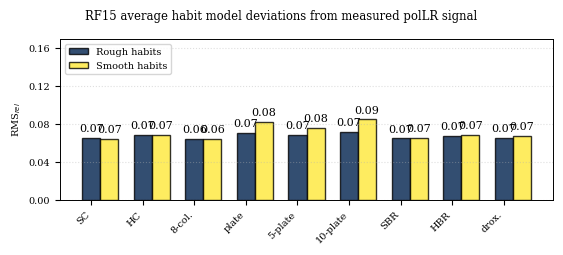

In [131]:
# Define the figure size based on textwidth
fig, ax = plt.subplots(figsize=(0.9*textwidth, textwidth / 2.5))
#fig, ax = plt.subplots(figsize=(0.8*textwidth,textwidth/2.5))

# Create a list of species names based on a dictionary
species = [name_dict[habit] for habit in diffs_rough.ic_habit.values]

# Define penguin data
penguin_means = {
    'Rough habits': mean_diffs_rough,
    'Smooth habits': mean_diffs_smooth,
}

# Define bar width and a multiplier for bar positioning
x = np.arange(len(species))
width = 0.35  # Increase bar width slightly for separation
multiplier = 0

# Use a color palette for bars (e.g., 'viridis')
colors = plt.cm.cividis(np.linspace(0, 1, len(penguin_means)))

# Plot each set of penguin data as grouped bars with distinct colors
for attribute, measurement, color in zip(penguin_means.keys(), penguin_means.values(), colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, alpha=0.8, color=color, edgecolor='black', linewidth=1, capstyle='round')
    ax.bar_label(rects, padding=3, fmt='%1.2f', fontsize=8)
    multiplier += 1

# Set x-axis labels and add a legend
ax.set_xticks(x)
ax.set_xticklabels(species, rotation=45, ha="right")  # Rotate and right-align x-axis labels
ax.legend(loc='upper left')

# Add grid lines, adjust layout, and display the plot
ax.grid(axis='y', linestyle='dotted', alpha=0.4)
fig.suptitle('RF15 average habit model deviations from measured polLR signal')  # Add a title
plt.xlabel(None)
ax.set_ylim((0, 0.17))
plt.ylabel(r"RMS$_{rel}$")
plt.yticks(np.linspace(0,0.16, num=5))
plt.tight_layout()

commit("RF15_habit_bar_chart.png")
plt.show()

In [121]:
rough_habits=[name_dict_rough[old_name] for old_name in diffs_rough.ic_habit.values]
new_rough_diffs = xr.DataArray(data=diffs_rough.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=diffs_rough.sample.values,
                                           ic_habit=rough_habits))

new_sizes_rough = xr.DataArray(data=relative_signal_rough.mean(dim='theta_mean').r_eff.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_rough.r_eff.sample.values,
                                           ic_habit=rough_habits))

new_depths_rough = xr.DataArray(data=relative_signal_rough.mean(dim='theta_mean').tau550.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_rough.tau550.sample.values,
                                           ic_habit=rough_habits))



smooth_habits=[name_dict_smooth[old_name] for old_name in diffs_smooth.ic_habit.values]
new_smooth_diffs = xr.DataArray(data=diffs_smooth.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=diffs_smooth.sample.values,
                                           ic_habit=smooth_habits))

new_sizes_smooth = xr.DataArray(data=relative_signal_smooth.mean(dim='theta_mean').r_eff.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_smooth.r_eff.sample.values,
                                           ic_habit=smooth_habits))

new_depths_smooth = xr.DataArray(data=relative_signal_smooth.mean(dim='theta_mean').tau550.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_smooth.tau550.sample.values,
                                           ic_habit=smooth_habits))

all_diffs = new_rough_diffs.combine_first(new_smooth_diffs)
all_sizes = new_sizes_rough.combine_first(new_sizes_smooth)
all_depths = new_depths_rough.combine_first(new_depths_smooth)

In [122]:
# Define properties for all valid sample points

best_habits = (swir_sample_coordinates.swir_x.copy()*np.nan).rename('best_fit')
best_sizes = best_habits.copy().rename('best size')
best_depths = best_habits.copy().rename('best optical thickness')
heights = best_habits.copy().rename('cloud_top_height')

diffs = all_diffs
sizes = all_sizes
depths = all_depths

for sample in best_habits.sample:
    try:
        habit_index = diffs.sel(sample=sample).argmin(dim='ic_habit').values.item()
        best_habits.loc[sample] = habit_index
        best_habit = diffs.ic_habit.values[habit_index]
        #print(f"Best habit: {diffs.ic_habit.values[habit_index]} at index {habit_index}")
    except: 
        #print('failed')
        continue
    if best_habits.loc[sample] != np.nan:
        best_size = sizes.sel(sample=sample, ic_habit=best_habit)
        best_sizes.loc[sample] = best_size
        
        best_depth = depths.sel(sample=sample, ic_habit=best_habit)
        best_depths.loc[sample] = best_depth
    else:
        best_sizes.loc[sample] = np.nan
        best_depths.loc[sample] = np.nan

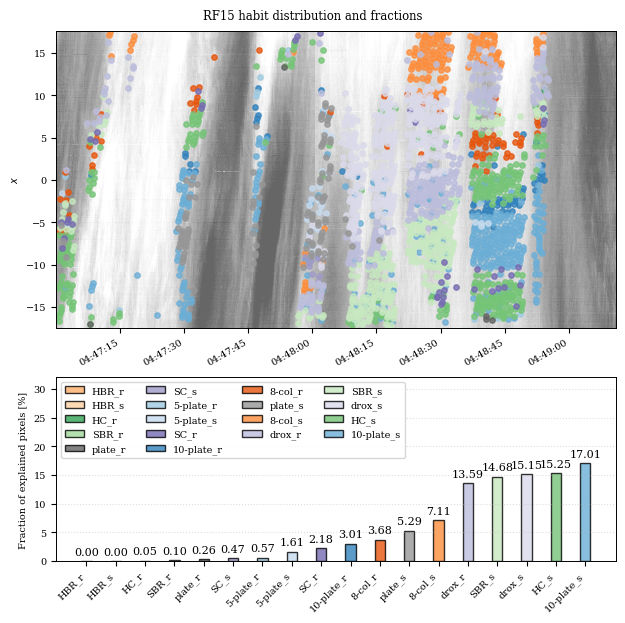

In [129]:
fig, axes = plt.subplots(nrows=2, figsize=(textwidth, textwidth), gridspec_kw={'height_ratios': [gr, 1]})
ax=axes[0]

swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.6, ax=ax)
#swir_coords.height.plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.6, ax=ax)


# Define the colormap and normalize it
cmap = matplotlib.cm.tab20c

# Create a scatter plot with the same colormap
for index, habit in enumerate(all_diffs.ic_habit.values):

    coords = swir_sample_coordinates.where(best_habits==index)
    
    ax.scatter(coords.swir_time.values,
               coords.swir_x.values,
               marker='o', color=cmap(index), alpha=0.8, s=15)#, norm=norm)


ax.set_xlabel(None)
ax.set_ylabel(r"$x$")
ax.set_title(None)
fig.suptitle("RF15 habit distribution and fractions")



ax = axes[1]
counts = [best_habits.where(best_habits==index).notnull().sum().values.item() for index in np.arange(all_diffs.ic_habit.size)] 
species_sorted = all_diffs.ic_habit.values[np.array(counts).argsort()]
colors_sorted = cmap(np.array(counts).argsort())
counts_sorted = np.array(counts)[np.array(counts).argsort()]

# Define penguin data
penguin_means = {
    'All habits': 100*(counts_sorted/np.sum(counts_sorted)),
}

# Define bar width and a multiplier for bar positioning
x = np.arange(len(species_sorted))
width = 0.35  # Increase bar width slightly for separation
multiplier = 0


# Plot each set of penguin data as grouped bars with distinct colors
for attribute, measurement in zip(penguin_means.keys(), penguin_means.values()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=species_sorted, alpha=0.8, color=colors_sorted, 
                   edgecolor='black', linewidth=1, capstyle='round')
    ax.bar_label(rects, padding=3, fmt='%1.2f', fontsize=8)
    multiplier += 1

# Set x-axis labels and add a legend
ax.set_xticks(x)
ax.set_xticklabels(species_sorted, rotation=45, ha="right")  # Rotate and right-align x-axis labels
ax.legend(loc='upper left', ncols=4)

# Add grid lines, adjust layout, and display the plot
ax.grid(axis='y', linestyle='dotted', alpha=0.4)
#fig.suptitle('Percentage of detected habits')  # Add a title
ax.set_xlabel(None)
ax.set_ylim((0,32))
ax.set_title(None)
ax.set_ylabel(r"Fraction of explained pixels [%]")

plt.tight_layout()
#commit("RF15_habit_map_and_ranking.png")
plt.show()

## RF03 Angular retrieval demo

In [536]:
pol = iceMACS.read_LUT('/scratch/v/Veronika.Poertge/ac3/cloudbow_retrieval_results_0_height_offset/concatenated_dennys_2_polb_with_latlonheight_with_viewing_angle.nc')
pol = pol.sel(color=0)

pol_ds = pol.sel(sample=pol.sample[::20])

swir_coords = iceMACS.read_LUT('/project/meteo/work/Weber.Ann/PhD/swir_phase/coords3D/swir_3D_coords_latlonheight_cth_10km_2022-03-13T08:51:00_2022-03-13T08:56:04_new.nc')
inflight_B = iceMACS.read_LUT('../mystic_tests/calibration_files/specMACS_POLB_cal_CHB2021+inflight.nc')

view_angles = iceMACS.read_LUT('../scenes/MWAI_RF03/data/view_angles.nc')
swir_scene = iceMACS.read_LUT('../scenes/MWAI_RF03/data/swir_scene.nc')
solar_positions = iceMACS.read_LUT('../scenes/MWAI_RF03/data/solar_positions.nc')
nas_scene = iceMACS.read_LUT('../scenes/MWAI_RF03/data/nas_scene.nc')

from iceMACS.tools import PixelInterpolator
interp = PixelInterpolator(swir_scene, window=2)
interp.add_cutoffs([2, 3, 0.2, 2])

filtered_swir_scene = swir_scene.copy()
filtered_swir_scene['radiance'] = interp.filtered_radiance(remove=True)

from iceMACS.tools import SceneInterpreter
scene = SceneInterpreter(filtered_swir_scene, view_angles, solar_positions)
#cloud_properties_rough = iceMACS.read_LUT('../scenes/MWAI_RF03/data/merged_cloud_properties_rough.nc').rolling(x=2, time=2).mean().where(scene.ice_index_Jaekel2013().rolling(x=4, time=50).mean()>1)
#cloud_properties_smooth = iceMACS.read_LUT('../scenes/MWAI_RF03/data/merged_cloud_properties_smooth.nc').rolling(x=2, time=2).mean().where(scene.ice_index_Jaekel2013().rolling(x=4, time=50).mean()>1)

In [537]:
from iceMACS.tools import PolSceneInterpreter
pol_scene = PolSceneInterpreter(pol, nas_scene, solar_positions)

In [538]:
sim_formatted_smooth = iceMACS.read_LUT('../scenes/MWAI_RF03/data/sim_formatted_smooth.nc')
sim_formatted_rough = iceMACS.read_LUT('../scenes/MWAI_RF03/data/sim_formatted_rough.nc')
swir_sample_coordinates = iceMACS.read_LUT('../scenes/MWAI_RF03/data/swir_sample_coordinates.nc')#.where(sim_formatted_rough != np.nan)

In [540]:
absolute_signal_rough = sim_formatted_rough.simulated_reflectivity.where(sim_formatted_rough.r_eff<60.)
relative_signal_rough = absolute_signal_rough/absolute_signal_rough.mean(dim='theta_mean', skipna=True)

absolute_signal_smooth = sim_formatted_smooth.simulated_reflectivity.where(sim_formatted_smooth.r_eff<60.)
relative_signal_smooth = absolute_signal_smooth/absolute_signal_smooth.mean(dim='theta_mean', skipna=True)

absolute_measured_reflectivity = pol_scene.polarized_reflectivity(inflight_B).sel(color='red', sample=pol_ds.sample)#.where(sim_formatted_rough.simulated_reflectivity.isel(ic_habit=0) != np.nan)
relative_measured_reflectivity = (absolute_measured_reflectivity/absolute_measured_reflectivity.mean(dim="theta_mean", skipna=True))

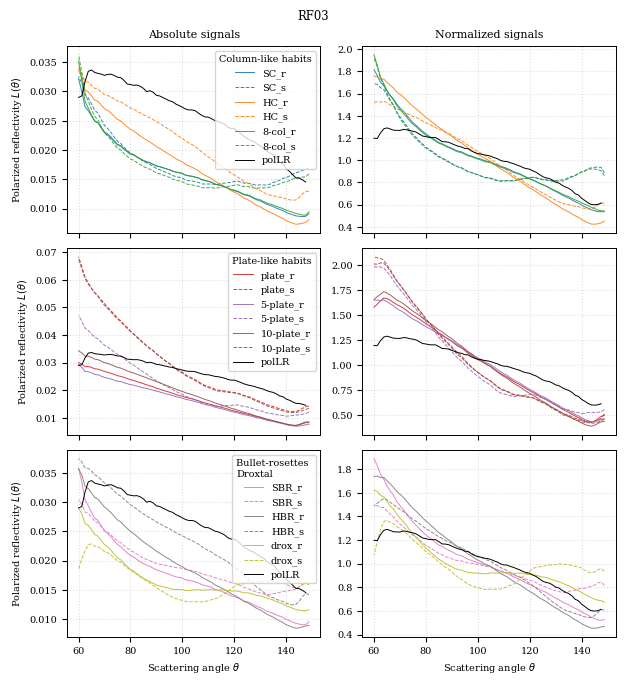

In [543]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(textwidth, textwidth*1.1), sharex=True)

color_counter=0
ax = axes[0,:]
for habit in column_habits:
    
    #absolutes 
    (absolute_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (absolute_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    #relatives
    (relative_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (relative_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    color_counter += 1
    
absolute_measured_reflectivity.mean(dim="sample").plot(ax=ax[0], color='black', label="polLR")
relative_measured_reflectivity.mean(dim="sample").plot(ax=ax[1], color='black', label="polLR")

ax[0].legend(title="Column-like habits")
ax[0].set_xlabel(None)
ax[0].set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[0].set_title("Absolute signals")
ax[1].set_title("Normalized signals")


ax = axes[1,:]
for habit in plate_habits:
    
    #absolutes 
    (absolute_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], label=name_dict_rough[habit], color=f"C{color_counter}", alpha=0.9)
    
    (absolute_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], linestyle='dashed', label=name_dict_smooth[habit], alpha=0.9, color=f"C{color_counter}")
    
    #relatives
    (relative_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (relative_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], linestyle='dashed', label=name_dict_smooth[habit], alpha=0.9, color=f"C{color_counter}")
    
    color_counter += 1
    
absolute_measured_reflectivity.mean(dim="sample").plot(ax=ax[0], color='black', label="polLR")
relative_measured_reflectivity.mean(dim="sample").plot(ax=ax[1], color='black', label="polLR")

ax[0].legend(title="Plate-like habits")
ax[0].set_xlabel(None)
ax[0].set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax[1].set_xlabel(None)
ax[1].set_ylabel(None)
ax[0].set_title(None)
ax[1].set_title(None)


ax = axes[2,:]
for habit in bullet_rosette_and_droxtal_habits:
    
    #absolutes 
    (absolute_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (absolute_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[0], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    #relatives
    (relative_signal_rough
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], label=name_dict_rough[habit], alpha=0.9, color=f"C{color_counter}")
    
    (relative_signal_smooth
     .sel(ic_habit=habit)).mean(dim="sample").plot(ax=ax[1], linestyle='dashed', alpha=0.9, label=name_dict_smooth[habit], color=f"C{color_counter}")
    
    color_counter += 1
    
absolute_measured_reflectivity.mean(dim="sample").plot(ax=ax[0], color='black', label="polLR")
relative_measured_reflectivity.mean(dim="sample").plot(ax=ax[1], color='black', label="polLR")

ax[0].legend(title="Bullet-rosettes \nDroxtal")
ax[0].set_xlabel(r"Scattering angle $\theta$")
ax[0].set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax[1].set_xlabel(r"Scattering angle $\theta$")
ax[1].set_ylabel(None)
ax[0].set_title(None)
ax[1].set_title(None)

for axis in axes.flatten():
    axis.grid(alpha=0.4, linestyle='dotted')
    
fig.suptitle("RF03")
plt.tight_layout()
#commit("RF03_phase_functions.png")

In [544]:
# cost functions
diffs_rough = np.square(relative_measured_reflectivity - relative_signal_rough).mean(dim="theta_mean")
mean_diffs_rough = diffs_rough.mean(dim="sample")
diffs_smooth = np.square(relative_measured_reflectivity - relative_signal_smooth).mean(dim="theta_mean")
mean_diffs_smooth = diffs_smooth.mean(dim="sample")


rough_habits=[name_dict_rough[old_name] for old_name in diffs_rough.ic_habit.values]
new_rough_diffs = xr.DataArray(data=diffs_rough.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=diffs_rough.sample.values,
                                           ic_habit=rough_habits))

new_sizes_rough = xr.DataArray(data=relative_signal_rough.mean(dim='theta_mean').r_eff.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_rough.r_eff.sample.values,
                                           ic_habit=rough_habits))

new_depths_rough = xr.DataArray(data=relative_signal_rough.mean(dim='theta_mean').tau550.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_rough.tau550.sample.values,
                                           ic_habit=rough_habits))



smooth_habits=[name_dict_smooth[old_name] for old_name in diffs_smooth.ic_habit.values]
new_smooth_diffs = xr.DataArray(data=diffs_smooth.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=diffs_smooth.sample.values,
                                           ic_habit=smooth_habits))

new_sizes_smooth = xr.DataArray(data=relative_signal_smooth.mean(dim='theta_mean').r_eff.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_smooth.r_eff.sample.values,
                                           ic_habit=smooth_habits))

new_depths_smooth = xr.DataArray(data=relative_signal_smooth.mean(dim='theta_mean').tau550.values,
                               dims=['sample', 'ic_habit'],
                               coords=dict(sample=relative_signal_smooth.tau550.sample.values,
                                           ic_habit=smooth_habits))

all_diffs = new_rough_diffs.combine_first(new_smooth_diffs)
all_sizes = new_sizes_rough.combine_first(new_sizes_smooth)
all_depths = new_depths_rough.combine_first(new_depths_smooth)


# Define properties for all valid sample points

best_habits = (swir_sample_coordinates.swir_x.copy()*np.nan).rename('best_fit')
best_sizes = best_habits.copy().rename('best size')
best_depths = best_habits.copy().rename('best optical thickness')

diffs = all_diffs
sizes = all_sizes
depths = all_depths

for sample in best_habits.sample:
    try:
        habit_index = diffs.sel(sample=sample).argmin(dim='ic_habit').values.item()
        best_habits.loc[sample] = habit_index
        best_habit = diffs.ic_habit.values[habit_index]
        #print(f"Best habit: {diffs.ic_habit.values[habit_index]} at index {habit_index}")
    except: 
        #print('failed')
        continue
    if best_habits.loc[sample] != np.nan:
        best_size = sizes.sel(sample=sample, ic_habit=best_habit)
        best_sizes.loc[sample] = best_size
        
        best_depth = depths.sel(sample=sample, ic_habit=best_habit)
        best_depths.loc[sample] = best_depth
    else:
        best_sizes.loc[sample] = np.nan
        best_depths.loc[sample] = np.nan
        

    

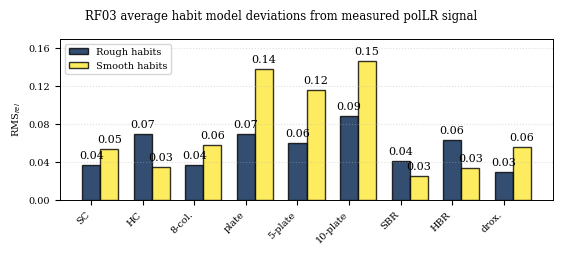

In [610]:
# Define the figure size based on textwidth
fig, ax = plt.subplots(figsize=(0.9*textwidth, textwidth / 2.5))
#fig, ax = plt.subplots(figsize=(0.8*textwidth,textwidth/2.5))

# Create a list of species names based on a dictionary
species = [name_dict[habit] for habit in diffs_rough.ic_habit.values]

# Define penguin data
penguin_means = {
    'Rough habits': mean_diffs_rough,
    'Smooth habits': mean_diffs_smooth,
}

# Define bar width and a multiplier for bar positioning
x = np.arange(len(species))
width = 0.35  # Increase bar width slightly for separation
multiplier = 0

# Use a color palette for bars (e.g., 'viridis')
colors = plt.cm.cividis(np.linspace(0, 1, len(penguin_means)))

# Plot each set of penguin data as grouped bars with distinct colors
for attribute, measurement, color in zip(penguin_means.keys(), penguin_means.values(), colors):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, alpha=0.8, color=color, edgecolor='black', linewidth=1, capstyle='round')
    ax.bar_label(rects, padding=3, fmt='%1.2f', fontsize=8)
    multiplier += 1

# Set x-axis labels and add a legend
ax.set_xticks(x)
ax.set_xticklabels(species, rotation=45, ha="right")  # Rotate and right-align x-axis labels
ax.legend(loc='upper left')

# Add grid lines, adjust layout, and display the plot
ax.grid(axis='y', linestyle='dotted', alpha=0.4)
fig.suptitle('RF03 average habit model deviations from measured polLR signal')  # Add a title
plt.xlabel(None)
ax.set_ylim((0, 0.17))
plt.ylabel(r"RMS$_{rel}$")
plt.yticks(np.linspace(0,0.16, num=5))
plt.tight_layout()

#commit("RF03_habit_bar_chart.png")
plt.show()

In [602]:
theta_grid = relative_measured_reflectivity.theta_mean
mean_angles = (swir_sample_coordinates.swir_x.copy()*np.nan).rename('average_theta')
number_of_angles = (swir_sample_coordinates.swir_x.copy()*np.nan).rename('number_of_angles')
scattering_angles = np.ones(len(all_diffs.ic_habit))

for sample in relative_measured_reflectivity.sample:
    
    valid_theta_positions = relative_measured_reflectivity.sel(sample=sample).notnull()
    valid_angles = theta_grid.where(valid_theta_positions)
    
    mean_angles.loc[sample]=valid_angles.mean().values.item()
    number_of_angles.loc[sample]=valid_theta_positions.sum()
    #relative_measured_reflectivity.sel(sample=sample).sel(theta_mean=valid_angles.dropna(dim='theta_mean')).plot()

ValueError: shape mismatch: value array of shape (21,) could not be broadcast to indexing result with 0 dimensions

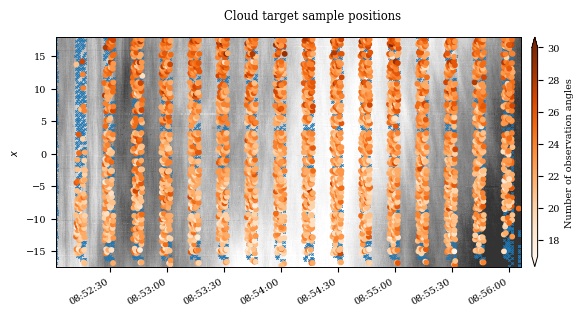

In [308]:
fig, ax = plt.subplots(figsize=(textwidth, textwidth / 2))
filtered_swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.8, ax=ax)

plt.scatter(swir_sample_coordinates.swir_time.values, 
            swir_sample_coordinates.swir_x.values,
            color='tab:blue', marker='x', s=3)

scatter = plt.scatter(swir_sample_coordinates.swir_time.values, 
            swir_sample_coordinates.swir_x.values,
            c=valid_angles, s=10*best_depths/best_depths, cmap='Oranges')
plt.colorbar(scatter, label="Number of observation angles", pad=0.02, extend='both', aspect=40)

plt.ylabel(r"$x$")
plt.xlabel(None)
ax.set_title(None)
fig.suptitle("Cloud target sample positions")
plt.tight_layout()
#commit("targets_on_cloud.png")
plt.show()

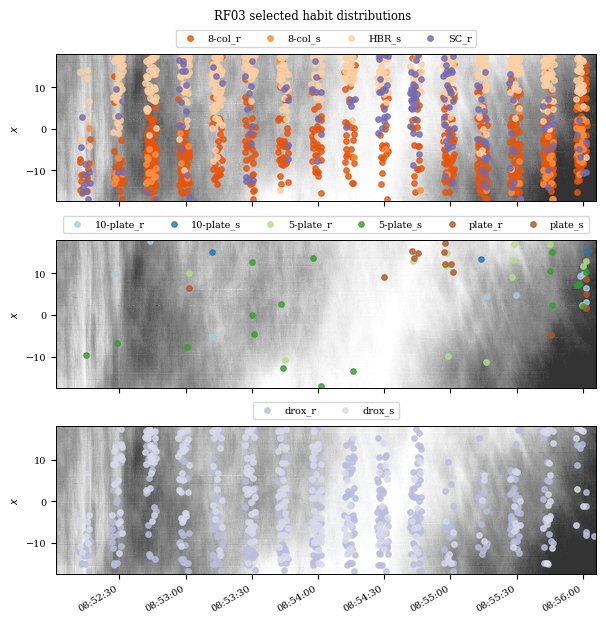

In [91]:
fig, axes = plt.subplots(nrows = 3, figsize=(textwidth, textwidth), sharex=True)

ax = axes[0]
cmap = matplotlib.cm.tab20c
all_counts = []
filtered_swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.8, ax=ax)

for index, habit in enumerate(all_diffs.ic_habit.values):

    coords = swir_sample_coordinates.where(best_habits==index)
    count = best_habits.where(best_habits==index).notnull().sum().values
    all_counts.append(count)
    
    
    if habit == habit=='8-col_s' or habit=='8-col_r' or habit=='SC_r' or habit=='HBR_s':
        ax.scatter(coords.swir_time.values,
                    coords.swir_x.values,
                    marker='o', color=cmap(index), alpha=0.8, s=15,label=f"{habit}")#, norm=norm)
        
ax.set_xlabel(None)
ax.set_ylabel(r"$x$")
ax.set_title(None)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=4)


ax = axes[1]
cmap = matplotlib.cm.Paired
all_counts = []
filtered_swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.8, ax=ax)

for index, habit in enumerate(all_diffs.ic_habit.values):

    coords = swir_sample_coordinates.where(best_habits==index)
    count = best_habits.where(best_habits==index).notnull().sum().values
    all_counts.append(count)
    
    
    if habit == habit=='plate_r' or habit=='plate_s':# or habit=='SC_r' or habit=='HBR_s':
        ax.scatter(coords.swir_time.values,
                    coords.swir_x.values,
                    marker='o', color=cmap(index), alpha=0.8, s=15,label=f"{habit}")#, norm=norm)
        
    if habit == habit=='10-plate_r' or habit=='10-plate_s':# or habit=='SC_r' or habit=='HBR_s':
        ax.scatter(coords.swir_time.values,
                    coords.swir_x.values,
                    marker='o', color=cmap(index), alpha=0.8, s=15,label=f"{habit}")#, norm=norm)
        
    if habit == habit=='5-plate_r' or habit=='5-plate_s':# or habit=='SC_r' or habit=='HBR_s':
        ax.scatter(coords.swir_time.values,
                    coords.swir_x.values,
                    marker='o', color=cmap(index), alpha=0.8, s=15,label=f"{habit}")#, norm=norm)

ax.set_xlabel(None)
ax.set_ylabel(r"$x$")
ax.set_title(None)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=6)

ax=axes[2]
cmap = matplotlib.cm.tab20c
all_counts = []
filtered_swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.8, ax=ax)

for index, habit in enumerate(all_diffs.ic_habit.values):

    coords = swir_sample_coordinates.where(best_habits==index)
    count = best_habits.where(best_habits==index).notnull().sum().values
    all_counts.append(count)
    
    
    if habit == habit=='drox_s' or habit=='drox_r':# or habit=='SC_r' or habit=='HBR_s':
        ax.scatter(coords.swir_time.values,
                    coords.swir_x.values,
                    marker='o', color=cmap(index), alpha=0.8, s=15,label=f"{habit}")#, norm=norm)
        
ax.set_xlabel(None)
ax.set_ylabel(r"$x$")
ax.set_title(None)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fancybox=True, ncol=6)


fig.suptitle("RF03 selected habit distributions")
plt.tight_layout()
commit("RF03_all_selections.png")
plt.show()

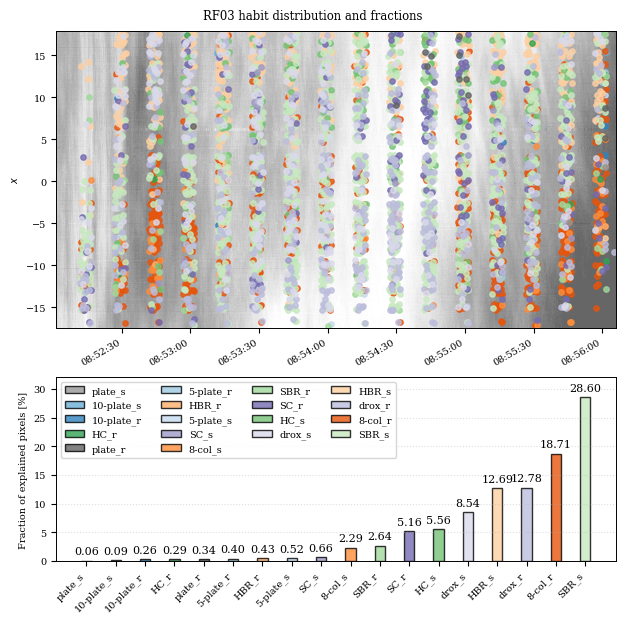

In [46]:
fig, axes = plt.subplots(nrows=2, figsize=(textwidth, textwidth), gridspec_kw={'height_ratios': [gr, 1]})
ax=axes[0]

filtered_swir_scene.sel(wavelength=1250, method='nearest').radiance.dropna(dim='x', how='all').plot(x='time', robust=True, add_colorbar=False, cmap='Greys_r', alpha=0.6, ax=ax)


# Define the colormap and normalize it
cmap = matplotlib.cm.tab20c

# Create a scatter plot with the same colormap
for index, habit in enumerate(all_diffs.ic_habit.values):

    coords = swir_sample_coordinates.where(best_habits==index)
    
    ax.scatter(coords.swir_time.values,
               coords.swir_x.values,
               marker='o', color=cmap(index), alpha=0.8, s=15)#, norm=norm)


ax.set_xlabel(None)
ax.set_ylabel(r"$x$")
ax.set_title(None)
fig.suptitle("RF03 habit distribution and fractions")



ax = axes[1]
counts = [best_habits.where(best_habits==index).notnull().sum().values.item() for index in np.arange(all_diffs.ic_habit.size)] 
species_sorted = all_diffs.ic_habit.values[np.array(counts).argsort()]
colors_sorted = cmap(np.array(counts).argsort())
counts_sorted = np.array(counts)[np.array(counts).argsort()]

# Define penguin data
penguin_means = {
    'All habits': 100*(counts_sorted/np.sum(counts_sorted)),
}

# Define bar width and a multiplier for bar positioning
x = np.arange(len(species_sorted))
width = 0.35  # Increase bar width slightly for separation
multiplier = 0


# Plot each set of penguin data as grouped bars with distinct colors
for attribute, measurement in zip(penguin_means.keys(), penguin_means.values()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=species_sorted, alpha=0.8, color=colors_sorted, 
                   edgecolor='black', linewidth=1, capstyle='round')
    ax.bar_label(rects, padding=3, fmt='%1.2f', fontsize=8)
    multiplier += 1

# Set x-axis labels and add a legend
ax.set_xticks(x)
ax.set_xticklabels(species_sorted, rotation=45, ha="right")  # Rotate and right-align x-axis labels
ax.legend(loc='upper left', ncols=4)

# Add grid lines, adjust layout, and display the plot
ax.grid(axis='y', linestyle='dotted', alpha=0.4)
#fig.suptitle('Percentage of detected habits')  # Add a title
ax.set_xlabel(None)
ax.set_ylim((0,32))
ax.set_title(None)
ax.set_ylabel(r"Fraction of explained pixels [%]")

plt.tight_layout()
commit("RF03_habit_map_and_ranking.png")
plt.show()

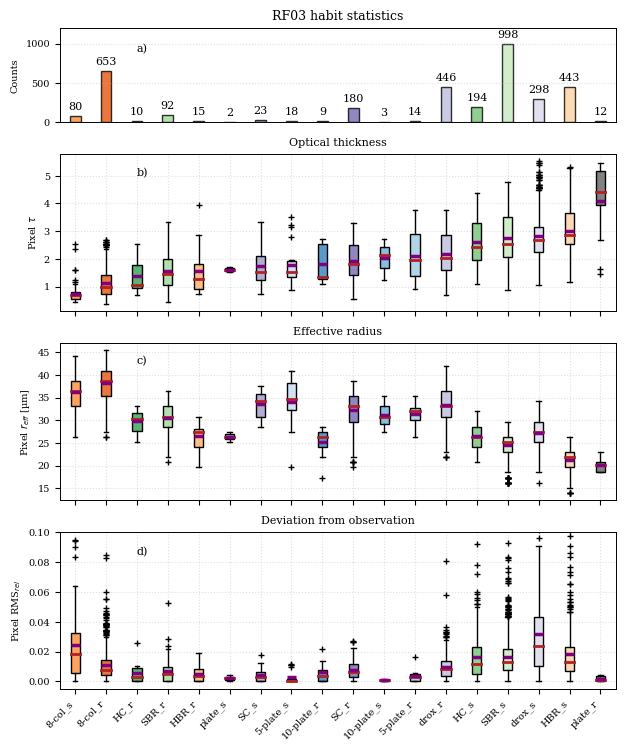

In [703]:

medianprops = dict(linestyle='-', linewidth=2, color='firebrick')
flierprops = dict(marker='+', markerfacecolor='black', markersize=4,
                  linestyle='none')
meanlineprops = dict(linestyle='--', linewidth=2.5, color='purple')


indices = np.arange(all_diffs.ic_habit.size)
mean_depths = [best_depths.where(best_habits==index).mean().values.item() for index in indices] 



sorted_indices = np.array(depths).argsort()

cmap=matplotlib.cm.tab20c






fig, axes = plt.subplots(nrows=4, figsize=(textwidth, 1.2*textwidth), gridspec_kw={'height_ratios': [0.6, 1, 1, 1]})


ax = axes[0]
counts = [best_habits.where(best_habits==index).notnull().sum().values.item() for index in np.arange(all_diffs.ic_habit.size)] 
species_sorted = all_diffs.ic_habit.values[np.array(mean_depths).argsort()]
colors_sorted = cmap(np.array(mean_depths).argsort())
counts_sorted = np.array(counts)[np.array(mean_depths).argsort()]

# Define penguin data
penguin_means = {
    'All habits': counts_sorted,
}

# Define bar width and a multiplier for bar positioning
x = np.arange(len(species_sorted))
width = 0.35  # Increase bar width slightly for separation
multiplier = 0


# Plot each set of penguin data as grouped bars with distinct colors
for attribute, measurement in zip(penguin_means.keys(), penguin_means.values()):
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=species_sorted, alpha=0.8, color=colors_sorted, 
                   edgecolor='black', linewidth=1, capstyle='round')
    ax.bar_label(rects, padding=3, fmt='%1.0f', fontsize=8)
    multiplier += 1

# Set x-axis labels and add a legend
#ax.set_xticks(x)
#ax.set_xticklabels(species_sorted, rotation=45, ha="right")  # Rotate and right-align x-axis labels
#ax.legend(loc='upper left', ncols=4)
ax.tick_params(axis='x', which='both',
               bottom=False, labelbottom=False)

# Add grid lines, adjust layout, and display the plot
ax.grid(axis='y', linestyle='dotted', alpha=0.4)
#fig.suptitle('Percentage of detected habits')  # Add a title
ax.set_xlabel(None)
#ax.set_ylim((0,32))
ax.set_title(None)
ax.set_ylabel(r"Counts")



ax = axes[1]
for index in indices:
    
    taus = best_depths.where(best_habits==sorted_indices[index]).dropna(dim='sample').values
    box = ax.boxplot(taus, positions=[index], patch_artist = True, labels=[""], flierprops=flierprops, meanline=True,
                                              boxprops = dict(facecolor = cmap(sorted_indices[index],
                                                                              alpha=0.8)), meanprops=meanlineprops, showmeans=True,
                     widths=0.3, showfliers=True, medianprops=medianprops)
    #box["boxes"][0].set_facecolor(cmap(sorted_indices[index]))

#ax.set_xticklabels(all_diffs.ic_habit[sorted_indices].values, rotation=45, ha='right')
ax.set_ylabel(r"Pixel $\tau$")
ax.grid(linestyle='dotted', alpha=0.4)
ax.set_title("Optical thickness")
ax.text(2, 5, 'b)', fontsize=fontsize+1)

ax = axes[2]
for index in indices:
    
    radii = best_sizes.where(best_habits==sorted_indices[index]).dropna(dim='sample').values
    box = ax.boxplot(radii, positions=[index], patch_artist = True, labels=[""], flierprops=flierprops, meanline=True,
                                              boxprops = dict(facecolor = cmap(sorted_indices[index],
                                                                              alpha=0.8)), meanprops=meanlineprops, showmeans=True,
                     widths=0.3, showfliers=True, medianprops=medianprops)
    
#ax.set_xticklabels(all_diffs.ic_habit[sorted_indices].values, rotation=45, ha='right')
ax.set_ylabel(r"Pixel $r_{eff}$ [µm]")
ax.grid(linestyle='dotted', alpha=0.4)
ax.set_title("Effective radius")
ax.text(2, 42.5, 'c)', fontsize=fontsize+1)

ax=axes[3]
for index in indices:
    
    differences = all_diffs.where(best_habits==sorted_indices[index]).isel(ic_habit=sorted_indices[index]).dropna(dim='sample').values
    box = ax.boxplot(differences, positions=[index], patch_artist = True, labels=[""], flierprops=flierprops, meanline=True,
                                              boxprops = dict(facecolor = cmap(sorted_indices[index],
                                                                              alpha=0.8)), meanprops=meanlineprops, showmeans=True,
                     widths=0.3, showfliers=True, medianprops=medianprops)

ax.set_xticklabels(all_diffs.ic_habit[sorted_indices].values, rotation=45, ha='right')
ax.set_ylabel(r"Pixel RMS$_{rel}$")
ax.set_ylim((-0.005, 0.1))
# plt.yscale('log')
ax.grid(linestyle='dotted', alpha=0.4)
ax.set_title("Deviation from observation")
ax.text(2, 0.085, 'd)', fontsize=fontsize+1)
axes[0].text(2, 900, 'a)', fontsize=fontsize+1)
axes[0].set_xlim((-0.5,17.5))
axes[0].set_ylim((0,1200))
axes[0].set_title("RF03 habit statistics", fontsize=fontsize+2)
plt.tight_layout()

commit("RF03_habits_by_tau.png")

## Case comparison

In [404]:
RF15_cp = iceMACS.read_LUT("../scenes/polar_low_RF15/data/RF15_merged_cloud_properties_rough.nc")
RF03_cp = iceMACS.read_LUT("../scenes/MWAI_RF03/data/merged_cloud_properties_rough.nc")

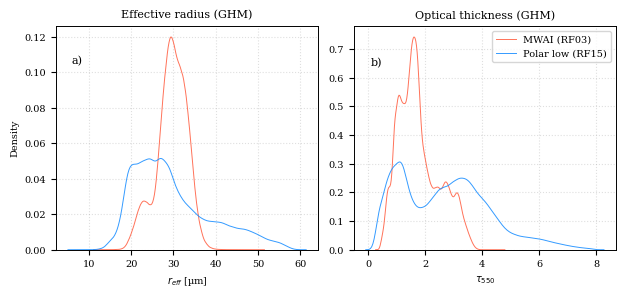

In [461]:
fig, axes = plt.subplots(ncols=2, figsize=((textwidth, textwidth/2.1)))

ax = axes[0]

RF03_ghm_reff = RF03_cp.sel(ic_habit='ghm').r_eff.values.flatten()
sns.kdeplot(data=RF03_ghm_reff, ax=ax, alpha=0.9, label="MWAI (RF03)", color='tomato')

RF15_ghm_reff = RF15_cp.sel(ic_habit='ghm').r_eff.values.flatten()
sns.kdeplot(data=RF15_ghm_reff, ax=ax, alpha=0.9, label="Polar low (RF15)", color='dodgerblue')

ax.set_xlabel(r"$r_{eff}$ [µm]")
ax.set_title("Effective radius (GHM)")
ax.text(6, 0.105, "a)", fontsize=fontsize+1)

ax = axes[1]

RF03_ghm_tau = RF03_cp.sel(ic_habit='ghm').tau550.values.flatten()
sns.kdeplot(data=RF03_ghm_tau, ax=ax, alpha=0.9, label="MWAI (RF03)", color='tomato')

RF15_ghm_tau = RF15_cp.sel(ic_habit='ghm').tau550.values.flatten()
sns.kdeplot(data=RF15_ghm_tau, ax=ax, alpha=0.9, label="Polar low (RF15)", color='dodgerblue')

ax.set_xlabel(r"$\tau_{550}$")
ax.set_ylabel(None)
ax.set_title("Optical thickness (GHM)")
ax.legend(loc='upper right')
ax.text(0.1, 0.64, "b)", fontsize=fontsize+1)

for ax in axes:
    ax.grid(alpha=0.4, linestyle='dotted')
    
plt.tight_layout()

commit("cloud_property_ghm_comparison.png")

In [436]:
RF15_sim_formatted_rough = iceMACS.read_LUT("../scenes/polar_low_RF15/data/sim_formatted_rough.nc")
RF15_sig_rough = RF15_sim_formatted_rough.simulated_reflectivity.where(RF15_sim_formatted_rough.r_eff<60.).mean(dim='sample')

RF15_sim_formatted_smooth = iceMACS.read_LUT("../scenes/polar_low_RF15/data/sim_formatted_smooth.nc")
RF15_sig_smooth = RF15_sim_formatted_smooth.simulated_reflectivity.where(RF15_sim_formatted_smooth.r_eff<60.).mean(dim='sample')


RF03_sim_formatted_rough = iceMACS.read_LUT("../scenes/MWAI_RF03/data/sim_formatted_rough.nc")
RF03_sig_rough = RF03_sim_formatted_rough.simulated_reflectivity.where(RF03_sim_formatted_rough.r_eff<60.).mean(dim='sample')

RF03_sim_formatted_smooth = iceMACS.read_LUT("../scenes/MWAI_RF03/data/sim_formatted_smooth.nc")
RF03_sig_smooth = RF03_sim_formatted_smooth.simulated_reflectivity.where(RF03_sim_formatted_smooth.r_eff<60.).mean(dim='sample')

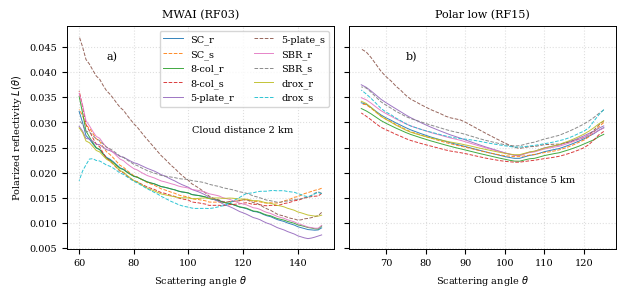

In [465]:
fig, axes = plt.subplots(ncols=2, figsize=((textwidth, textwidth/2.1)), sharey=True)

ax = axes[0]

for habit in RF03_sig_rough.ic_habit[::2]:
    RF03_sig_rough.sel(ic_habit=habit).plot(ax=ax, alpha=0.9, label=iceMACS.name_dict_rough[habit.values.item()])
    RF03_sig_smooth.sel(ic_habit=habit).plot(ax=ax, alpha=0.9, label=iceMACS.name_dict_smooth[habit.values.item()], linestyle='dashed')

ax.set_xlabel(r"Scattering angle $\theta$")
ax.set_ylabel(r"Polarized reflectivity $L(\theta)$")
ax.set_title("MWAI (RF03)")
ax.legend(loc='upper right', ncols=2)
ax.text(120, 0.028, "Cloud distance 2 km", horizontalalignment='center')
ax.text(70, 0.0425, "a)", fontsize=fontsize+1)

ax = axes[1]

for habit in RF15_sig_rough.ic_habit[::2]:
    RF15_sig_rough.sel(ic_habit=habit).plot(ax=ax, alpha=0.9, label=iceMACS.name_dict_rough[habit.values.item()])
    RF15_sig_smooth.sel(ic_habit=habit).plot(ax=ax, alpha=0.9, label=iceMACS.name_dict_smooth[habit.values.item()], linestyle='dashed')

ax.set_xlabel(r"Scattering angle $\theta$")
ax.set_ylabel(None)
ax.set_title("Polar low (RF15)")
ax.text(105, 0.018, "Cloud distance 5 km", horizontalalignment='center')
ax.text(75, 0.0425, "b)", fontsize=fontsize+1)
for ax in axes:
    ax.grid(alpha=0.4, linestyle='dotted')
    
plt.tight_layout()

commit("phase_functions_comparison.png")